In [593]:
# importing the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [594]:
# initializing the scalers

scaler_min = MinMaxScaler()
scaler_pow = PowerTransformer()

In [595]:
# defining a function to calculate the root mean square error

def rmse(x, y):
    return np.sqrt(mean_squared_error(x, y))

In [596]:
# Load the dataset
df = pd.read_csv("hungary_chickenpox.csv")

df.head(3)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   
2  17/01/2005        96       44    31     86      93        30     93    84   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  

[3 rows x 21 columns]

In [598]:
# performing data preprocessing

df.insert(0, "Week", [i for i in range(1, len(df) + 1)])

df.head(3)

Week        Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   
0     1  03/01/2005       168       79    30    173     169        42    136  \
1     2  10/01/2005       157       60    30     92     200        53     51   
2     3  17/01/2005        96       44    31     86      93        30     93   

   GYOR  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0   120  ...   130       57       2   178      66        64     11   29  \
1    70  ...    80       50      29   141      48        29     58   53   
2    84  ...    64       46       4   157      33        33     24   18   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  

[3 rows x 22 columns]

In [599]:
county_list = df.columns.to_list()
county_list.remove('Week')
county_list.remove('Date')

county_list

['BUDAPEST',
 'BARANYA',
 'BACS',
 'BEKES',
 'BORSOD',
 'CSONGRAD',
 'FEJER',
 'GYOR',
 'HAJDU',
 'HEVES',
 'JASZ',
 'KOMAROM',
 'NOGRAD',
 'PEST',
 'SOMOGY',
 'SZABOLCS',
 'TOLNA',
 'VAS',
 'VESZPREM',
 'ZALA']

In [600]:
# initializing dictionary to hold the average rmse values of all the models to be tested

model_mean_rmse = {}

Polynomial Regression:

MinMax Scaler, no log

In [601]:
x = df['Week'].values.reshape(-1, 1) # extracting week to be the input variable x
y_df = df[county_list] # each county to be a separate y variable

In [602]:
x_scaled_min = scaler_min.fit_transform(x) # normalizing the x variable (y will be normalised later [each county separately])
x_scaled_pow = scaler_pow.fit_transform(x)

In [603]:
# Split the x dataset into train and test sets
x_train_min, x_test_min = train_test_split(x_scaled_min, test_size=0.2, random_state=101)
x_train_pow, x_test_pow = train_test_split(x_scaled_pow, test_size=0.2, random_state=101)

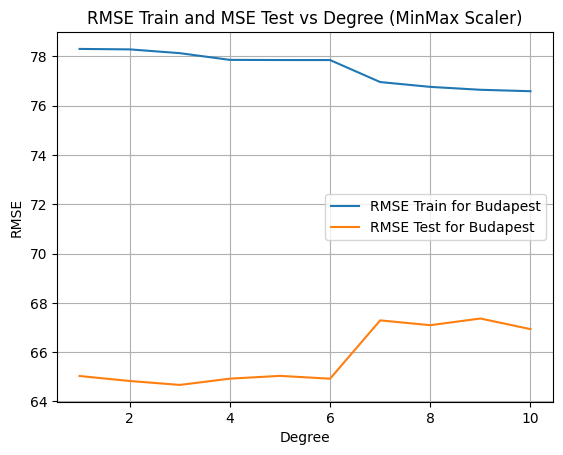

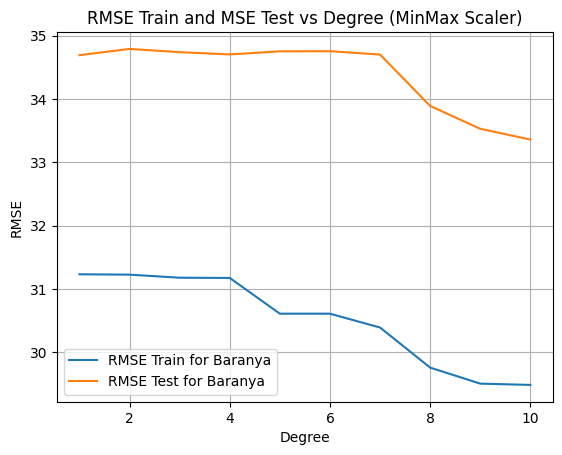

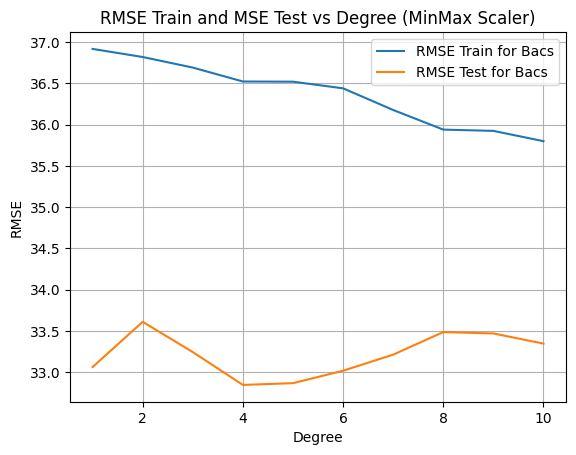

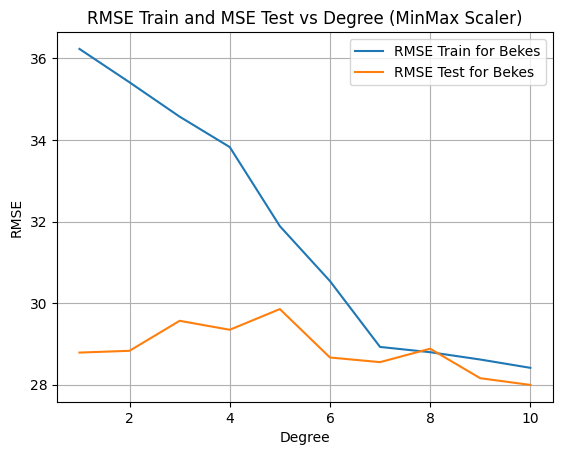

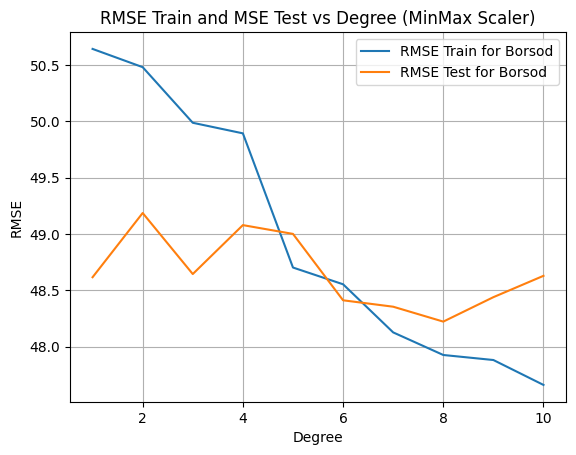

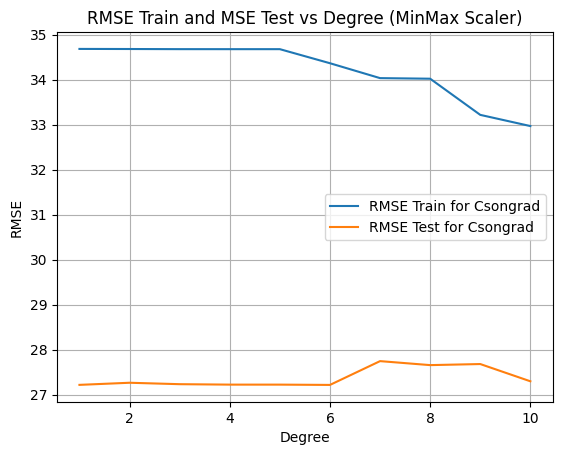

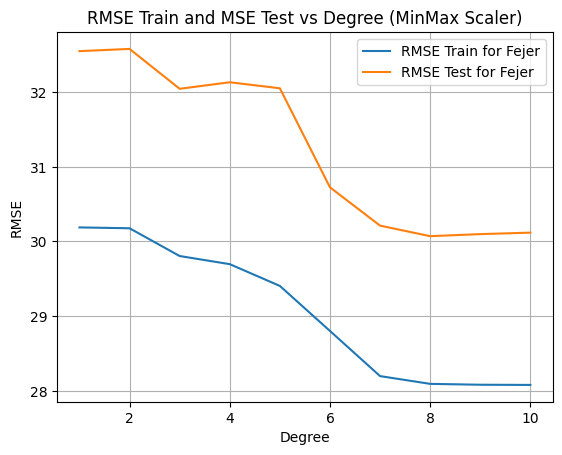

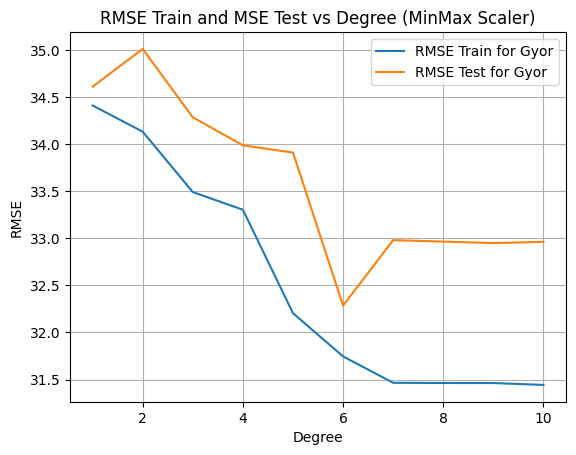

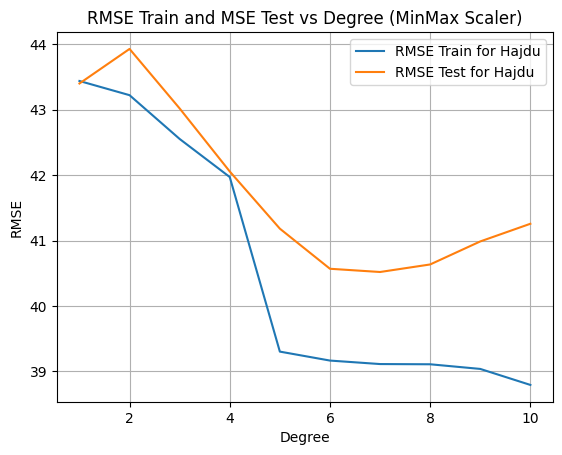

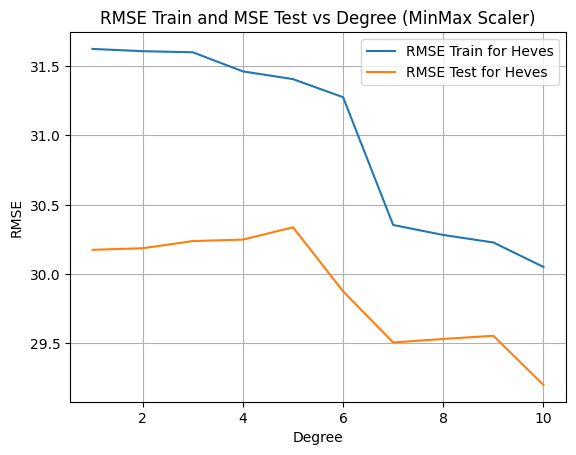

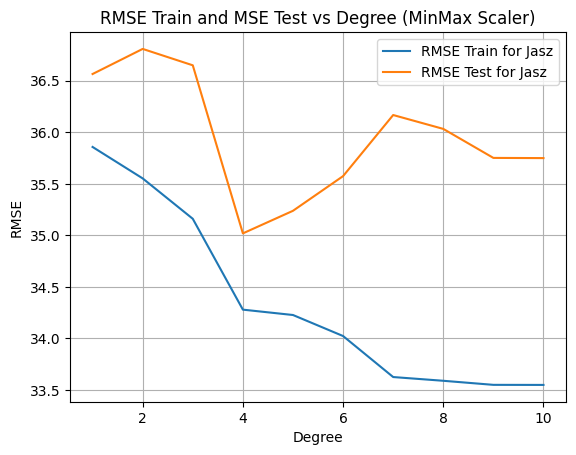

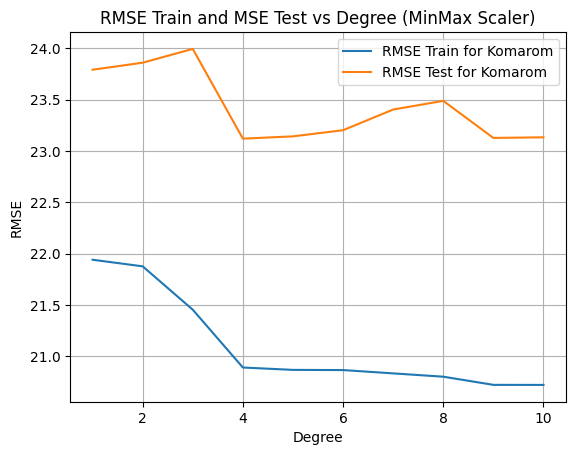

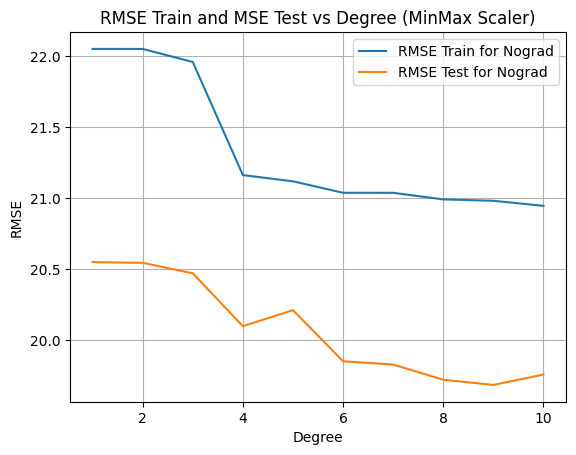

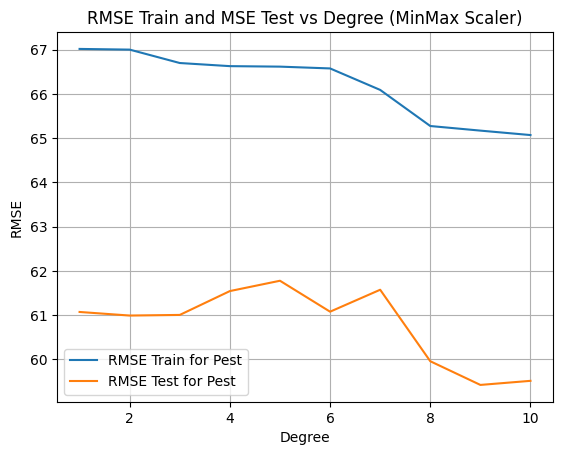

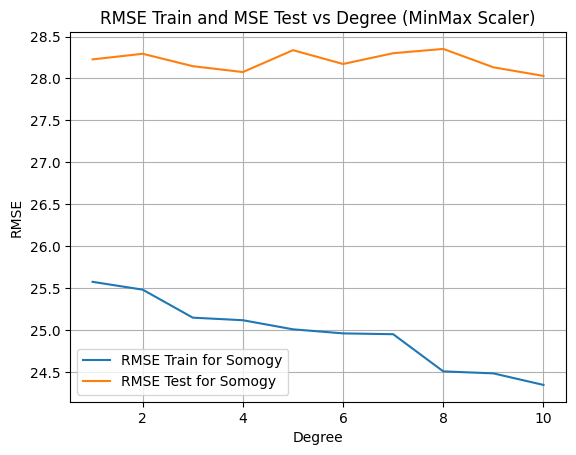

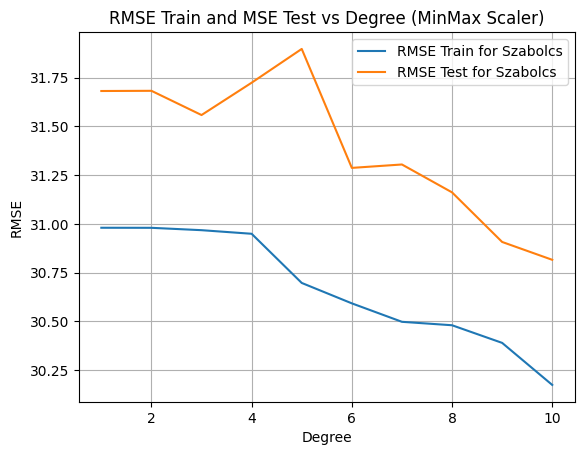

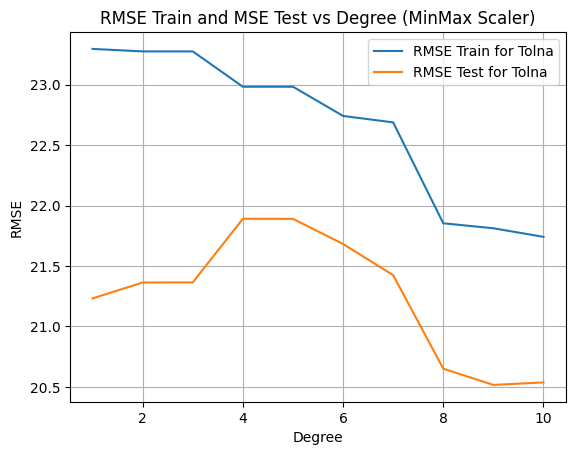

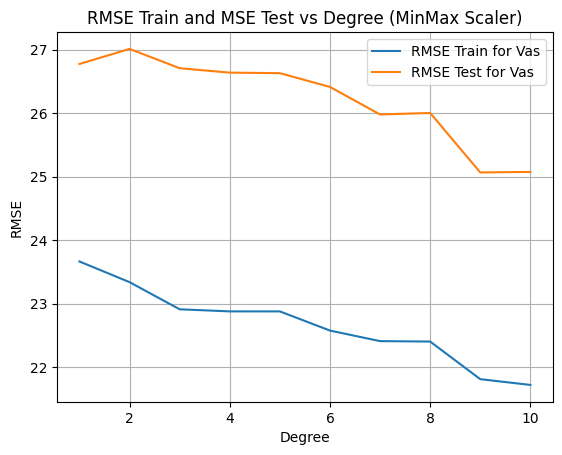

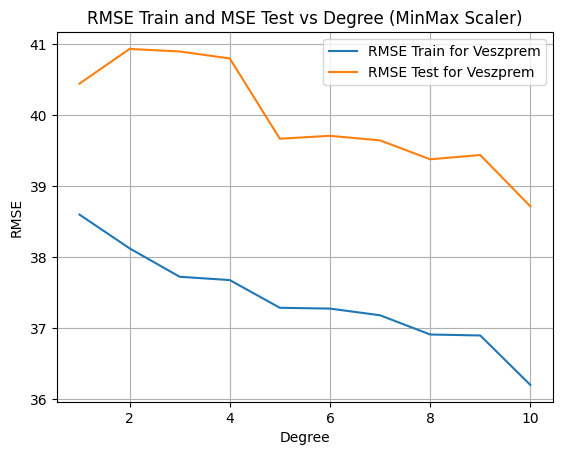

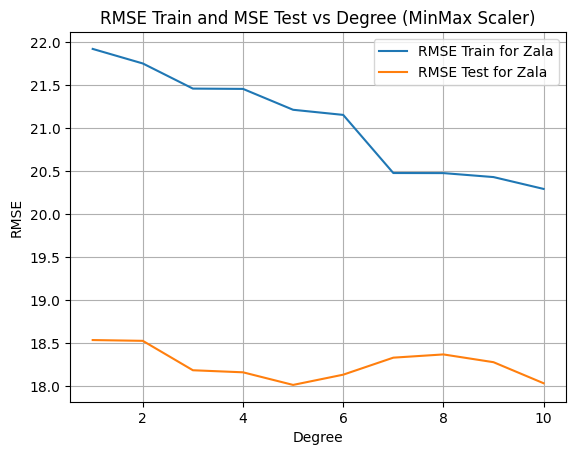

In [604]:
degrees = range(1, 11)
rmse_test_min = []
rmse_train_min = []

best_degrees_min = []

for county in county_list:

    rmse_test_county_min = []
    rmse_train_county_min = []
    
    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        # Normalize the target variable
        y_scaled_min = scaler_min.fit_transform(y.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_min, y_test_min = train_test_split(y_scaled_min, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_min = poly_features.fit_transform(x_train_min)
        x_test_poly_min = poly_features.transform(x_test_min)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_min, y_train_min)

        # Predict y values for train and test sets
        y_train_pred_min = model.predict(x_train_poly_min)
        y_test_pred_min = model.predict(x_test_poly_min)

        # performing inverse transform so that we have uniform scaling for errors
        y_train_pred_min = scaler_min.inverse_transform(y_train_pred_min.reshape(-1, 1))
        y_train_min = scaler_min.inverse_transform(y_train_min.reshape(-1, 1))

        y_test_pred_min = scaler_min.inverse_transform(y_test_pred_min.reshape(-1, 1))
        y_test_min = scaler_min.inverse_transform(y_test_min.reshape(-1, 1))

        rmse_train_county_min.append(rmse(y_train_pred_min, y_train_min))
        rmse_test_county_min.append(rmse(y_test_pred_min, y_test_min))

    rmse_test_min.append(np.min(rmse_test_county_min))
    rmse_train_min.append(rmse_test_county_min[np.argmin(rmse_test_county_min)])
    best_degrees_min.append(np.argmin(rmse_test_county_min) + 1)


    plt.plot(degrees, rmse_train_county_min, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_min, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (MinMax Scaler)')
    plt.legend()
    plt.grid(True)
    plt.show()

MinMax scaler, log

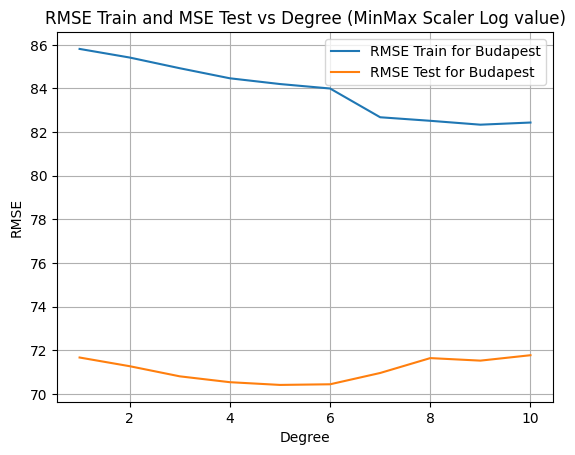

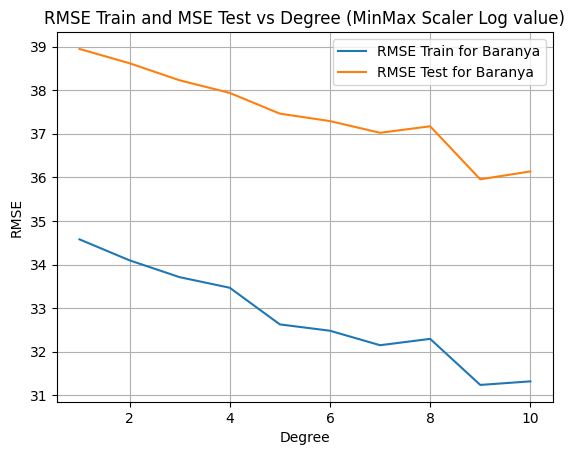

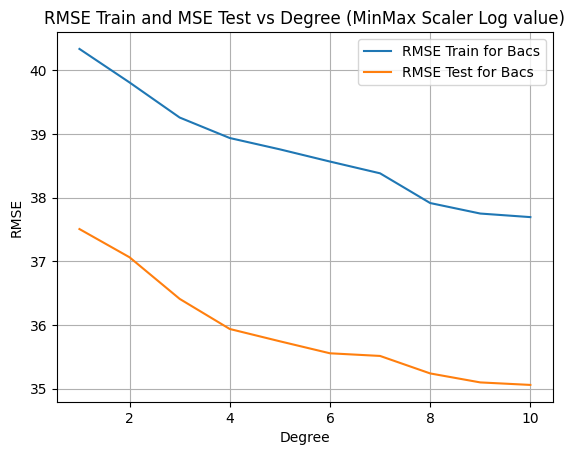

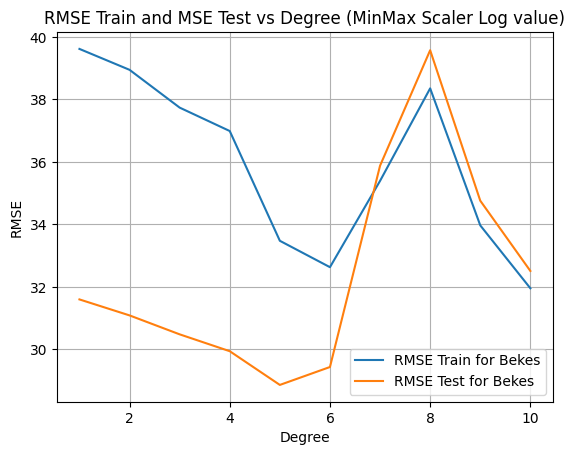

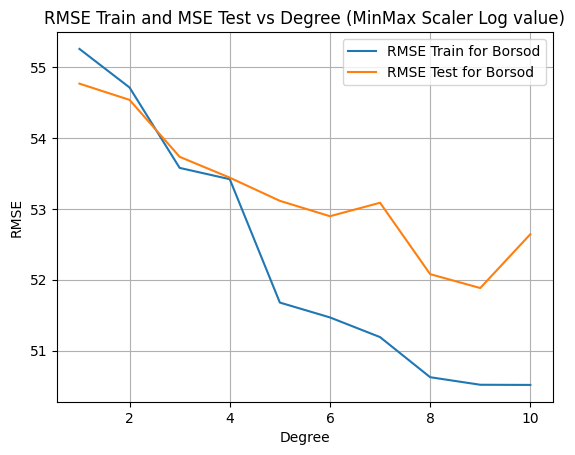

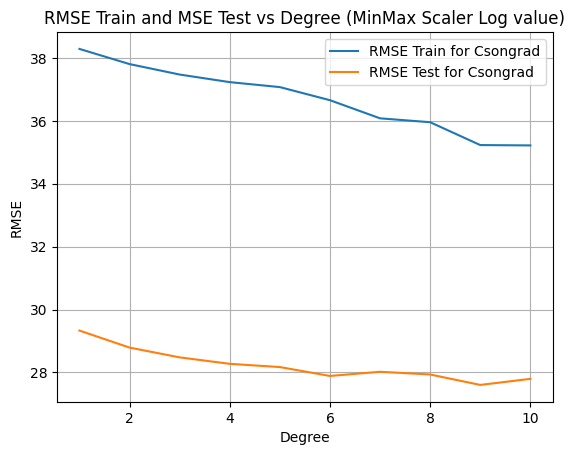

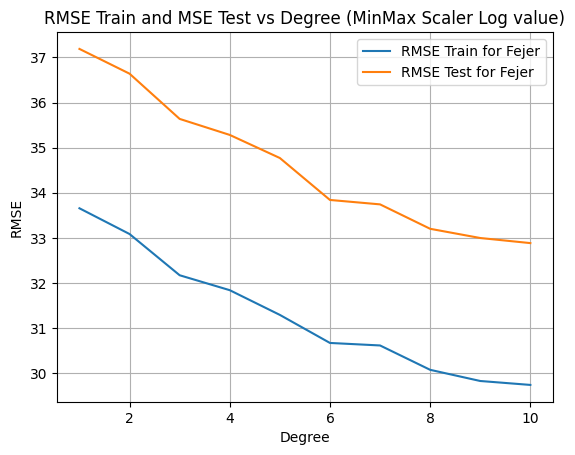

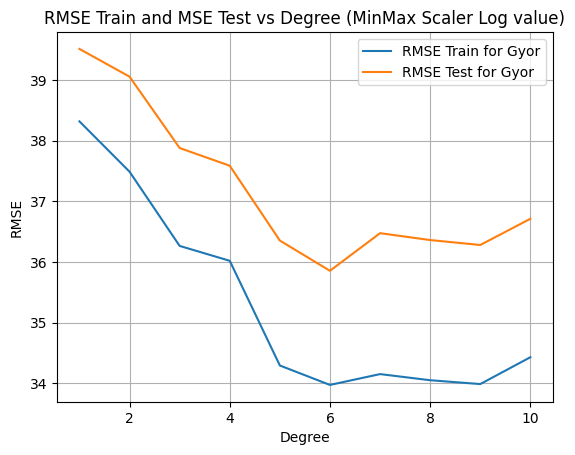

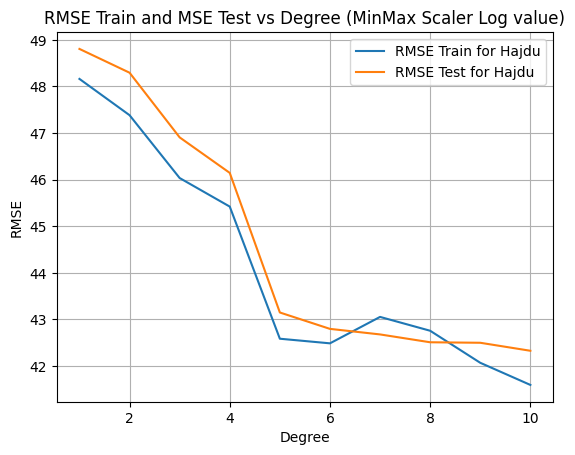

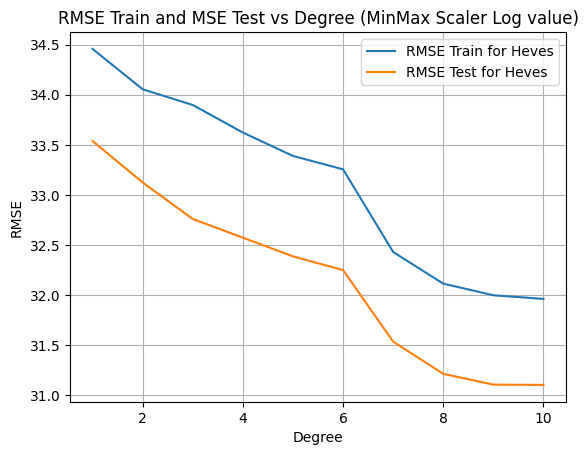

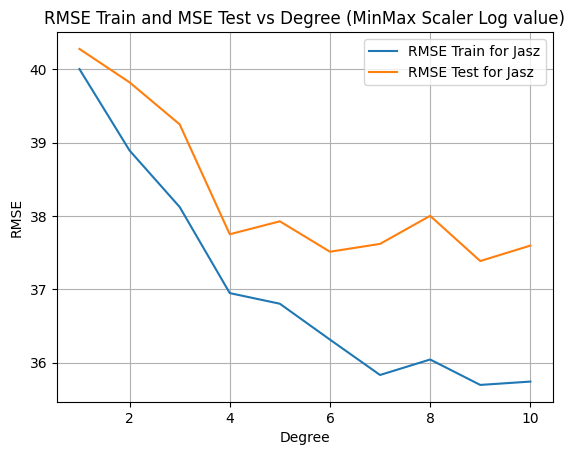

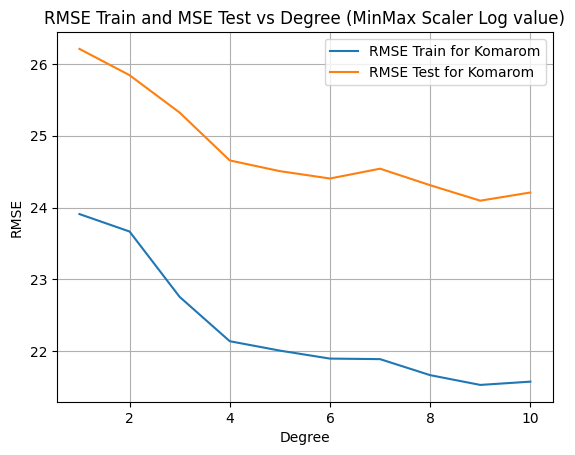

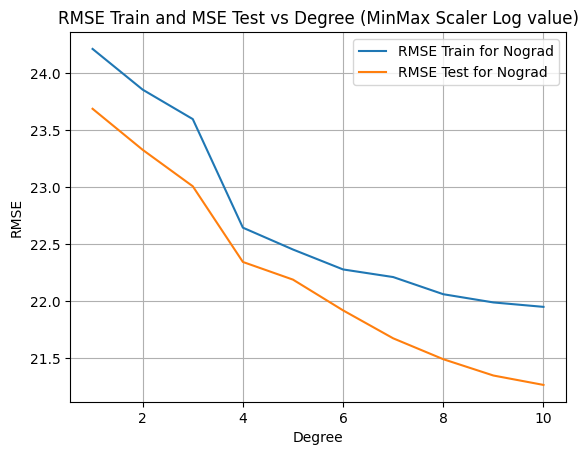

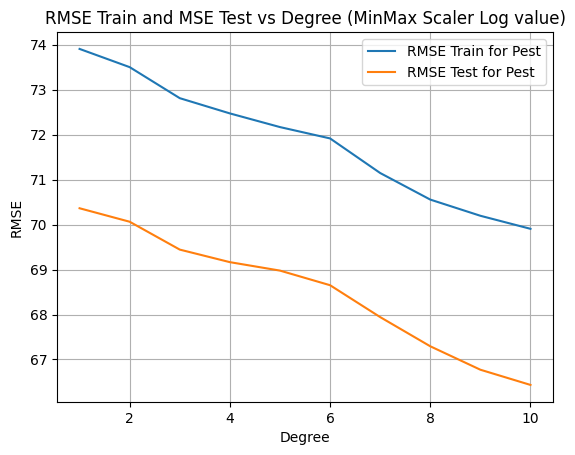

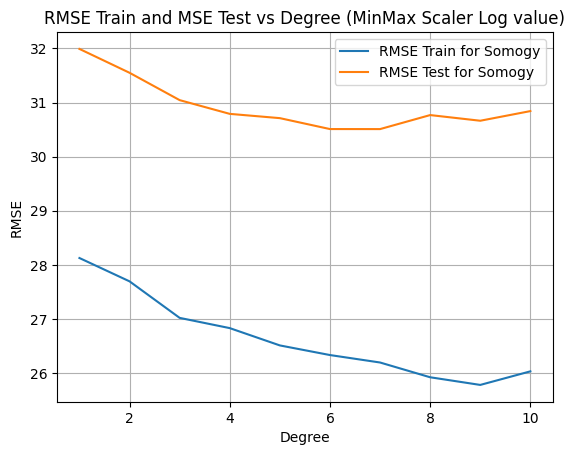

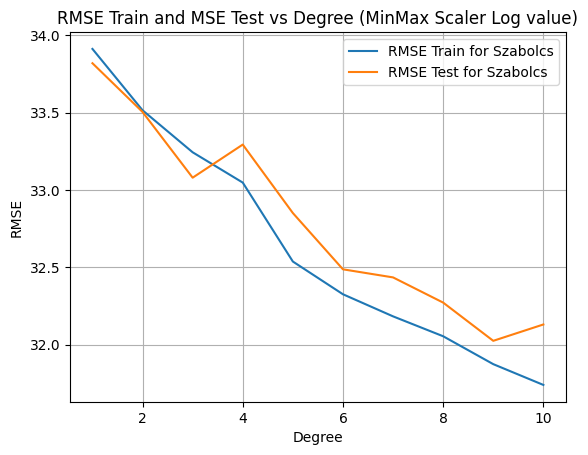

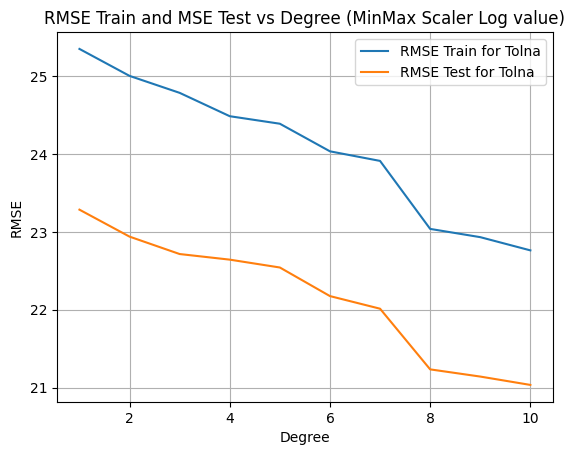

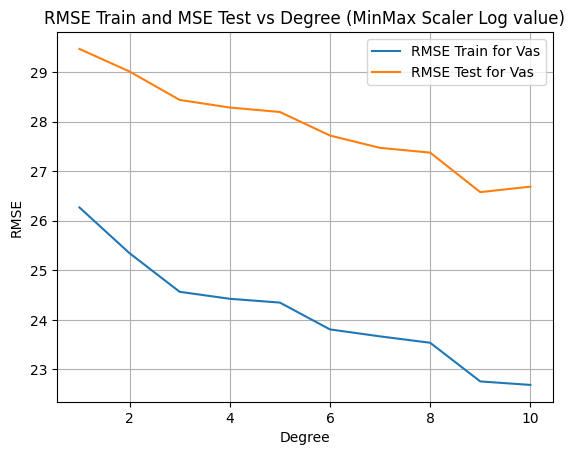

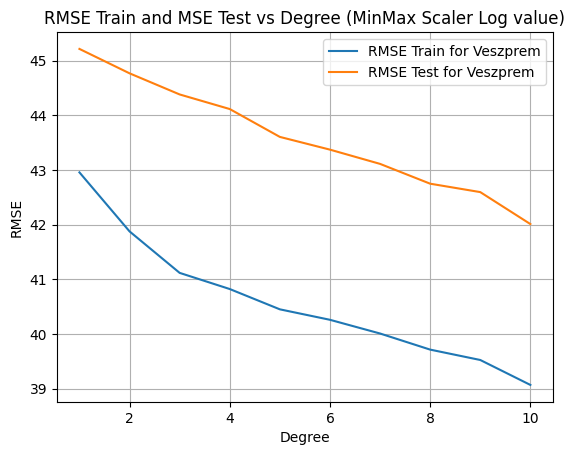

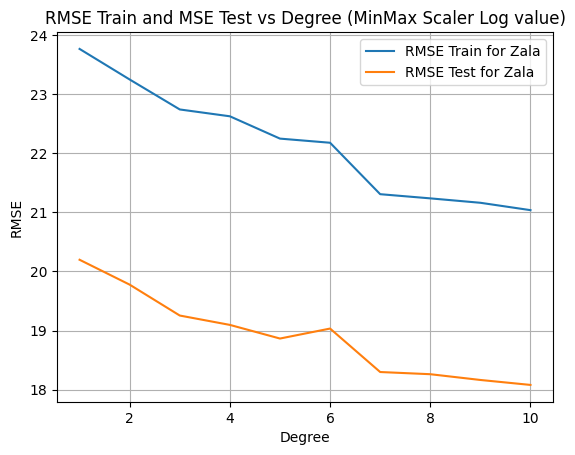

In [605]:
degrees = range(1, 11)
rmse_test_min_log = []
rmse_train_min_log = []

best_degrees_min_log = []

for county in county_list:

    rmse_test_county_min_log = []
    rmse_train_county_min_log = []  

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        y += 1

        # Logarithmic transformation of y
        y_log = np.log(y)

        # Normalize the target variable
        y_scaled_min_log = scaler_min.fit_transform(y_log.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_min_log, y_test_min_log = train_test_split(y_scaled_min_log, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_min = poly_features.fit_transform(x_train_min)
        x_test_poly_min = poly_features.transform(x_test_min)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_min, y_train_min_log)

        # Predict y values for train and test sets
        y_train_pred_min_log = model.predict(x_train_poly_min)
        y_test_pred_min_log = model.predict(x_test_poly_min)

        # Performing inverse transform so that we have uniform scaling for errors
        y_train_pred_min_log = scaler_min.inverse_transform(y_train_pred_min_log.reshape(-1, 1))
        y_train_min_log = scaler_min.inverse_transform(y_train_min_log.reshape(-1, 1))

        y_test_pred_min_log = scaler_min.inverse_transform(y_test_pred_min_log.reshape(-1, 1))
        y_test_min_log = scaler_min.inverse_transform(y_test_min_log.reshape(-1, 1))

        # Detransforming y_pred_min and y_test_min
        y_train_pred_min_log = np.exp(y_train_pred_min_log)
        y_test_pred_min_log = np.exp(y_test_pred_min_log)

        y_train_min_log = np.exp(y_train_min_log)
        y_test_min_log = np.exp(y_test_min_log)

        # calculating errors
        rmse_train_county_min_log.append(rmse(y_train_pred_min_log, y_train_min_log))
        rmse_test_county_min_log.append(rmse(y_test_pred_min_log, y_test_min_log))
        
    rmse_test_min_log.append(np.min(rmse_test_county_min_log))
    rmse_train_min_log.append(rmse_test_county_min_log[np.argmin(rmse_test_county_min_log)])
    best_degrees_min_log.append(np.argmin(rmse_test_county_min_log) + 1)

    plt.plot(degrees, rmse_train_county_min_log, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_min_log, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (MinMax Scaler Log value)')
    plt.legend()
    plt.grid(True)
    plt.show()


PowerTransformer, no log

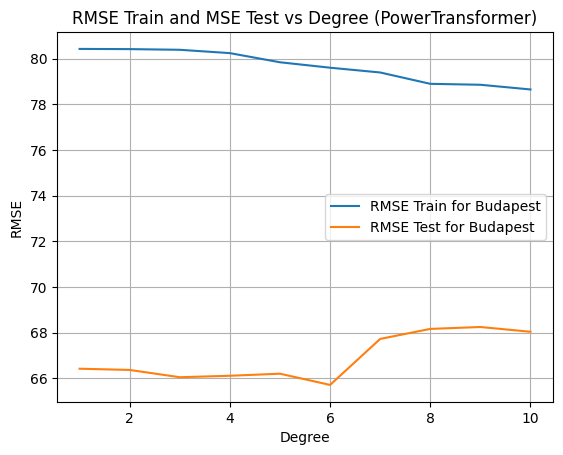

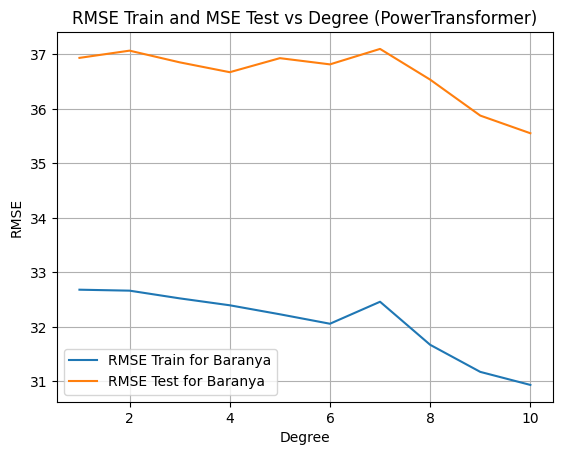

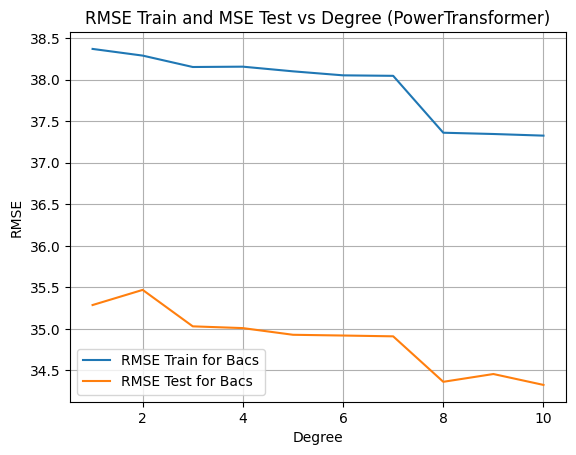

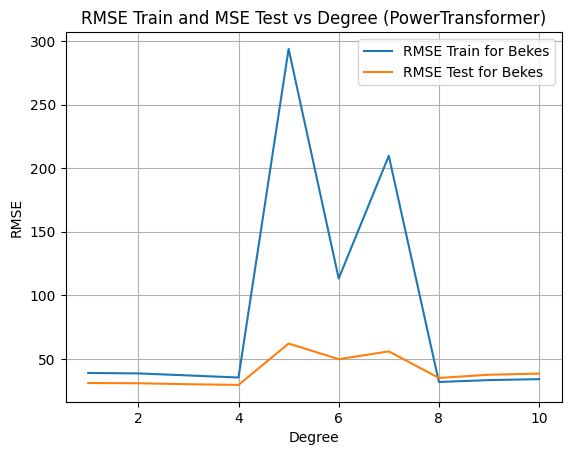

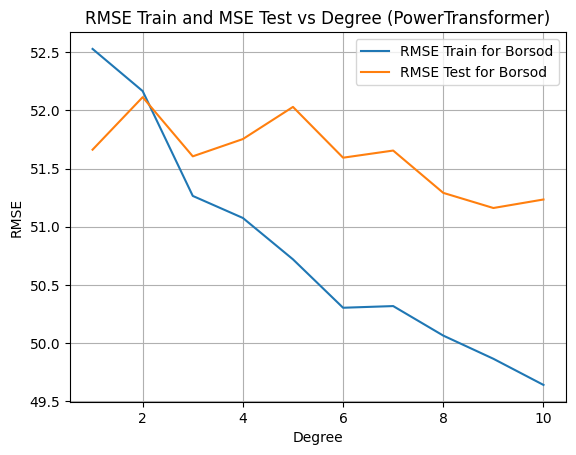

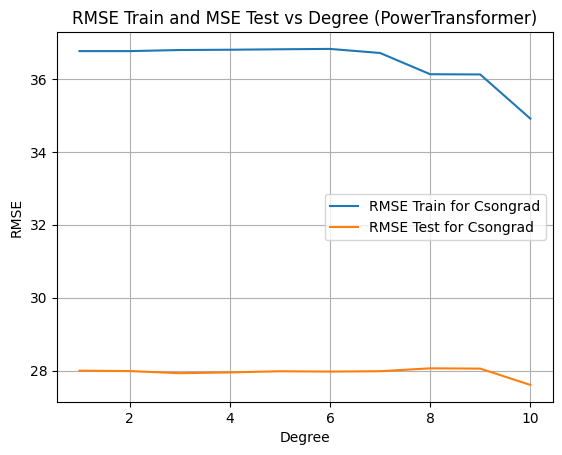

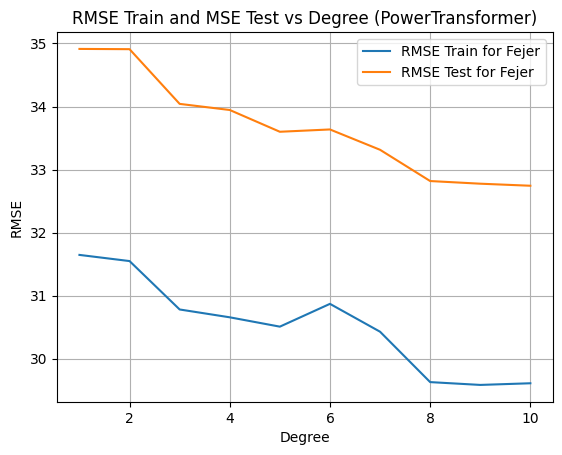

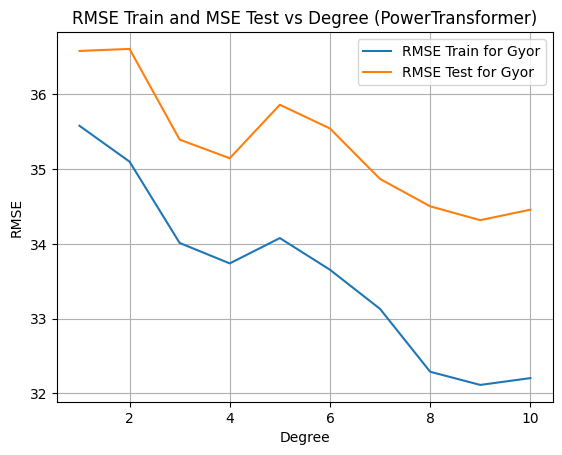

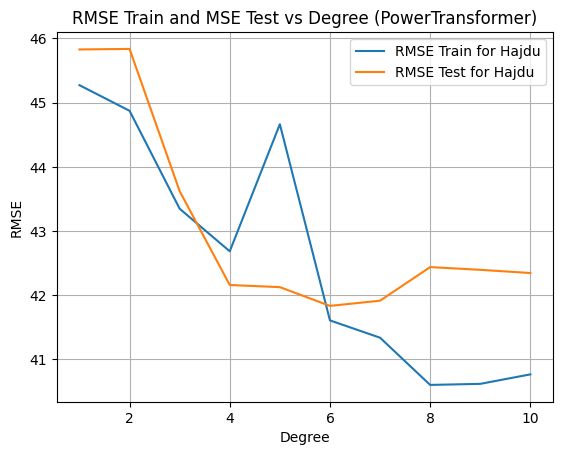

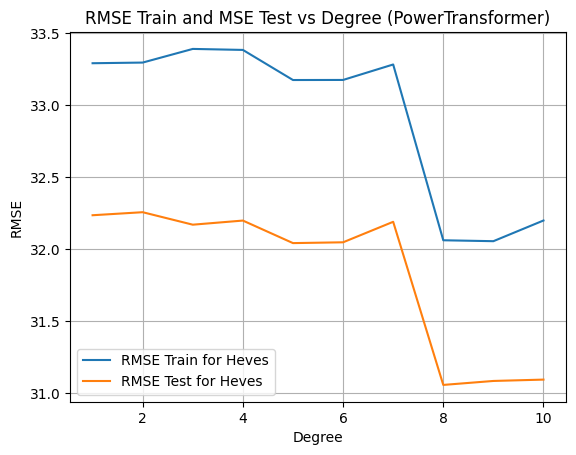

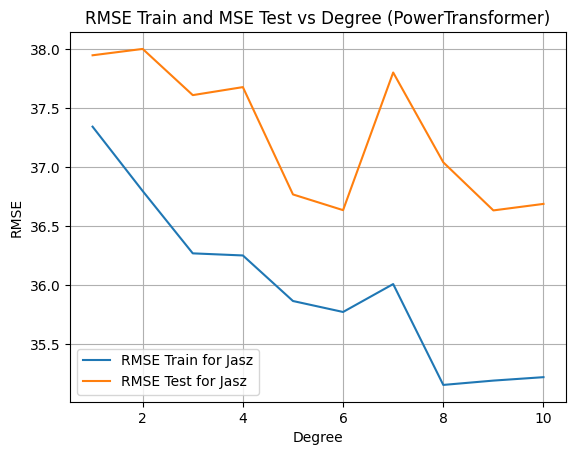

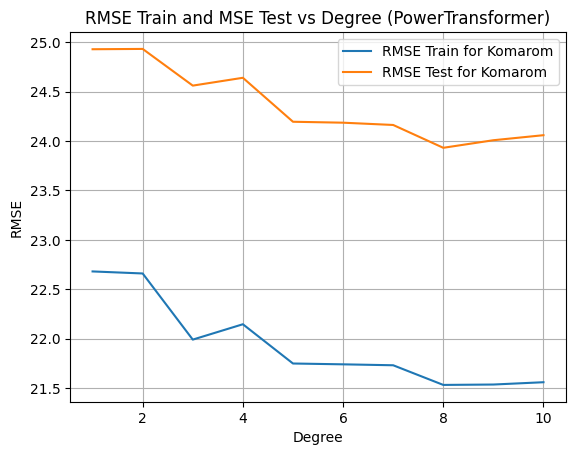

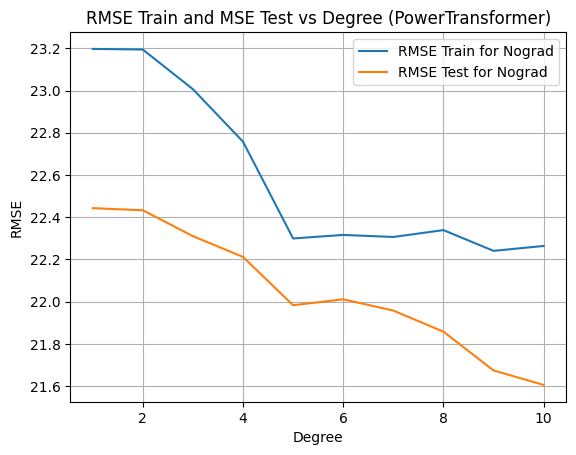

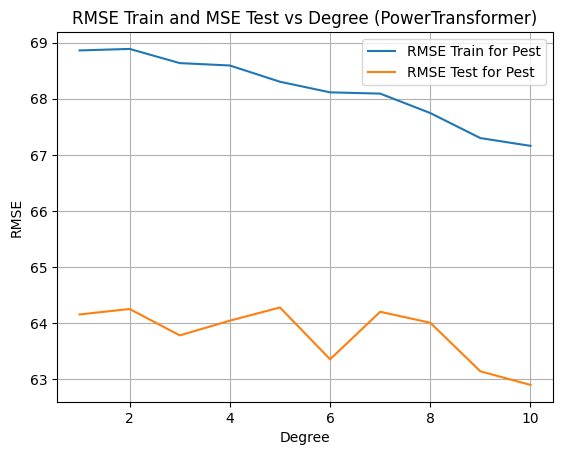

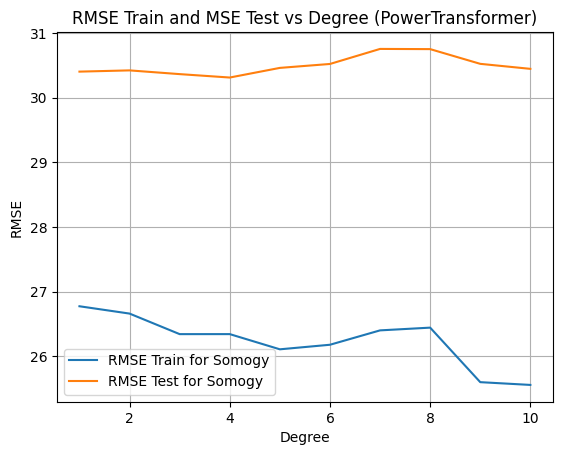

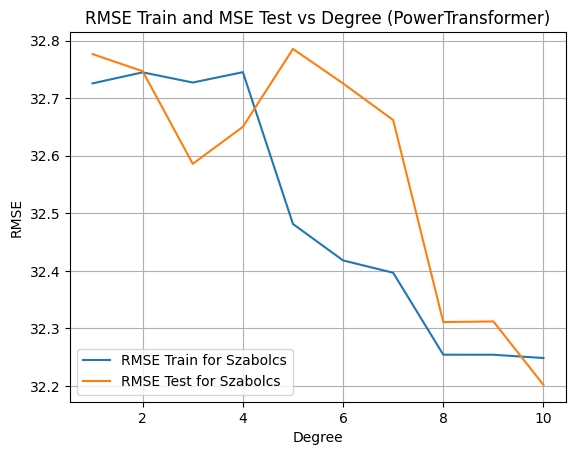

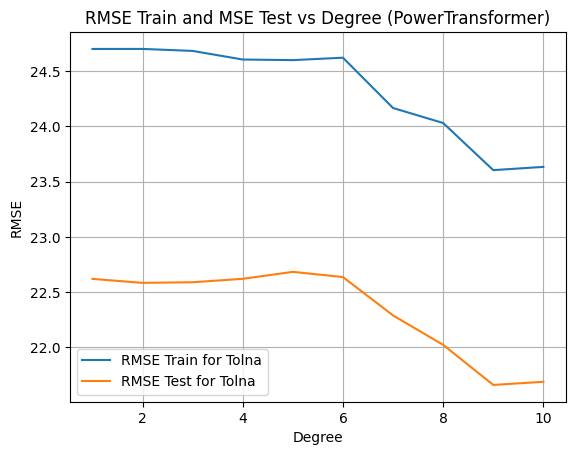

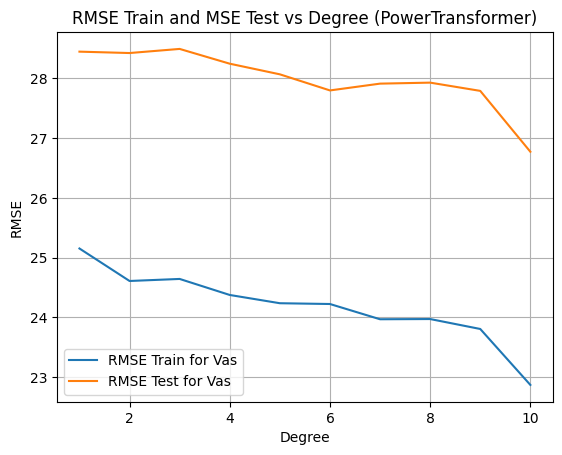

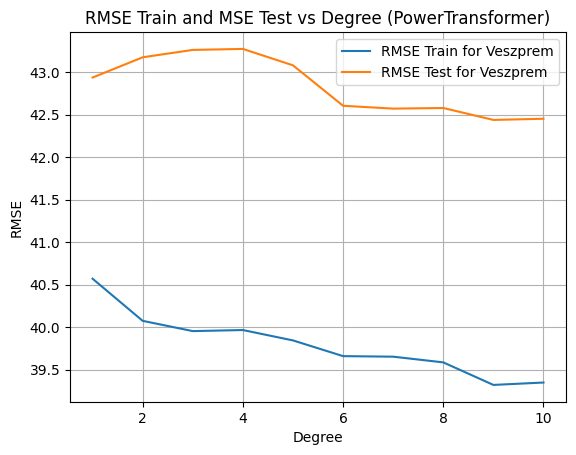

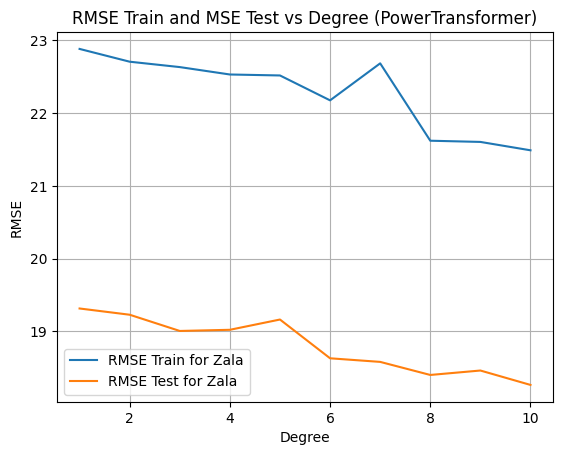

In [606]:
rmse_test_pow = []
rmse_train_pow = []

best_degrees_pow = []

for county in county_list:

    rmse_test_county_pow = []
    rmse_train_county_pow = []

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        # Normalize the target variable
        y_scaled_pow = scaler_pow.fit_transform(y.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_pow, y_test_pow = train_test_split(y_scaled_pow, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_pow = poly_features.fit_transform(x_train_pow)
        x_test_poly_pow = poly_features.transform(x_test_pow)

        # Fit polynomial regression model POW
        model = LinearRegression()
        model.fit(x_train_poly_pow, y_train_pow)

        # Predict y values for train and test sets
        y_train_pred_pow = model.predict(x_train_poly_pow)
        y_test_pred_pow = model.predict(x_test_poly_pow)

        # performing inverse transform so that we have uniform scaling for errors
        y_train_pred_pow = scaler_pow.inverse_transform(y_train_pred_pow.reshape(-1, 1))
        y_train_pow = scaler_pow.inverse_transform(y_train_pow.reshape(-1, 1))

        y_test_pred_pow = scaler_pow.inverse_transform(y_test_pred_pow.reshape(-1, 1))
        y_test_pow = scaler_pow.inverse_transform(y_test_pow.reshape(-1, 1))

        rmse_train_county_pow.append(rmse(y_train_pred_pow, y_train_pow))
        rmse_test_county_pow.append(rmse(y_test_pred_pow, y_test_pow))

    rmse_test_pow.append(np.min(rmse_test_county_pow))
    rmse_train_pow.append(rmse_test_county_pow[np.argmin(rmse_test_county_pow)])
    best_degrees_pow.append(np.argmin(rmse_test_county_pow) + 1)

    plt.plot(degrees, rmse_train_county_pow, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_pow, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (PowerTransformer)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [619]:
PowerTransformer, log

NameError: name 'log' is not defined

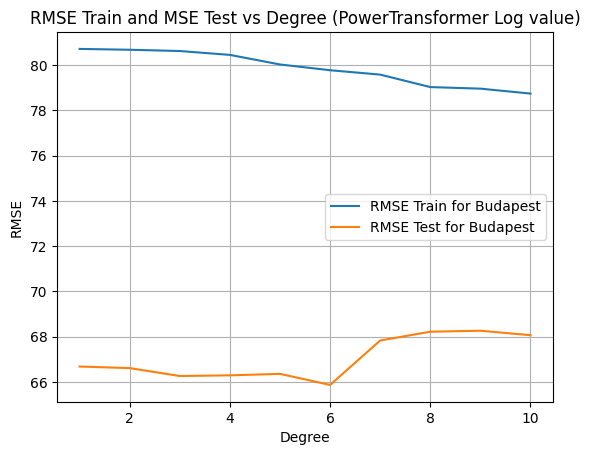

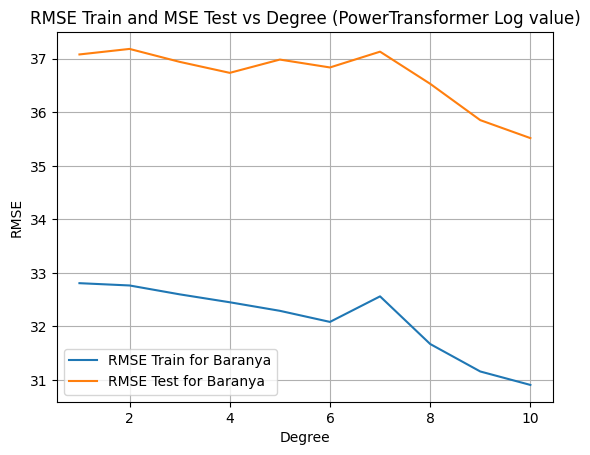

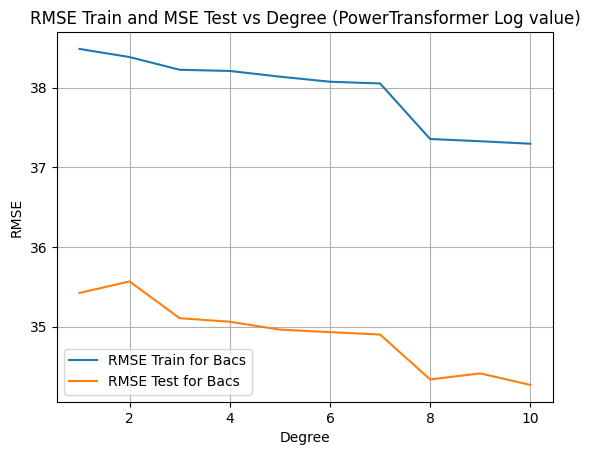

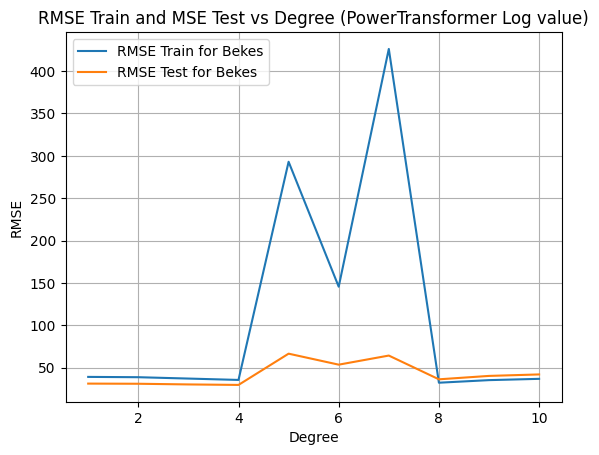

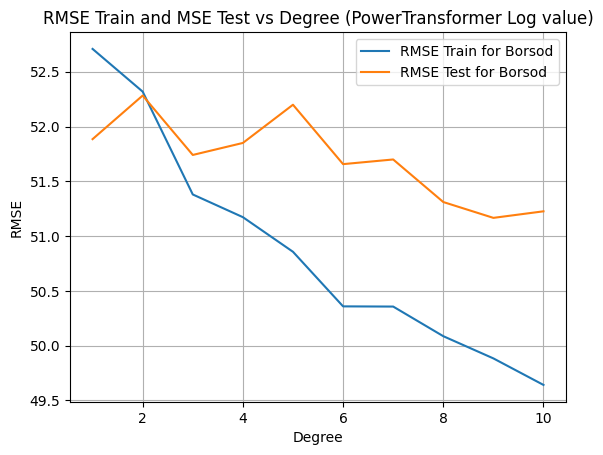

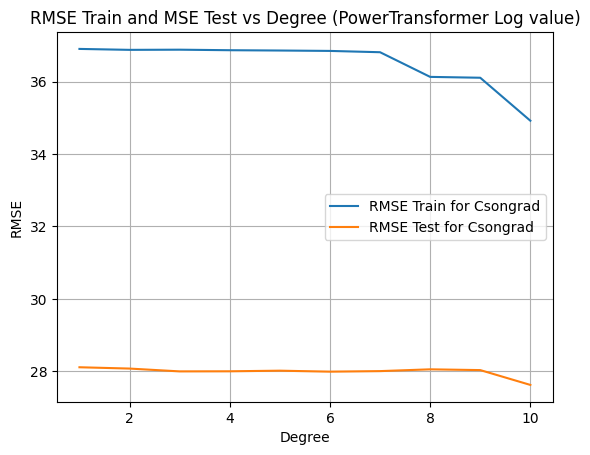

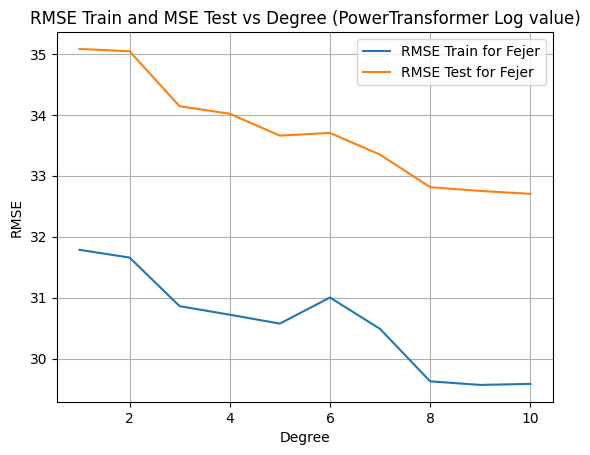

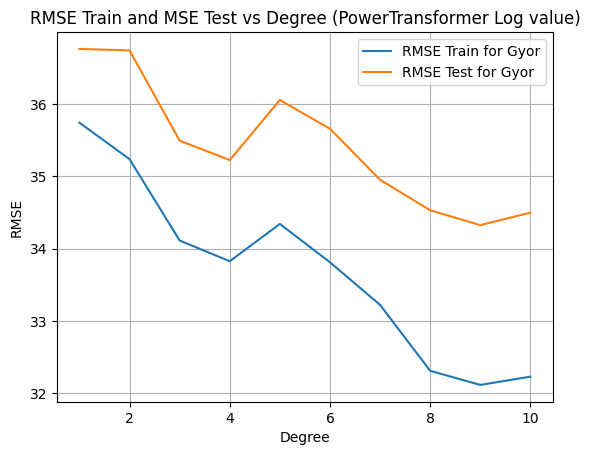

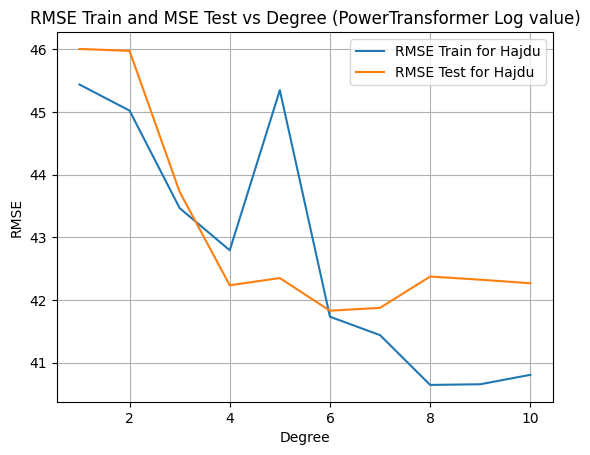

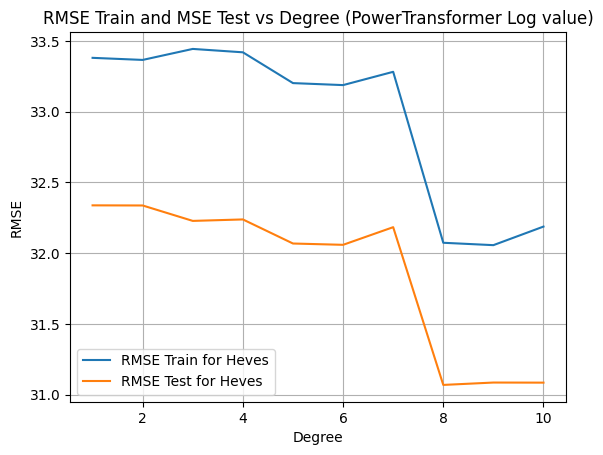

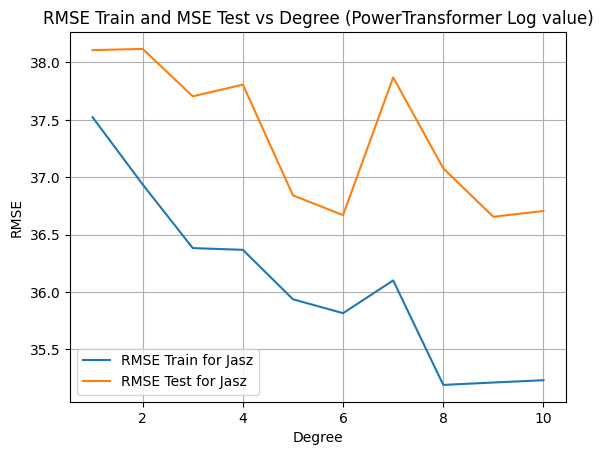

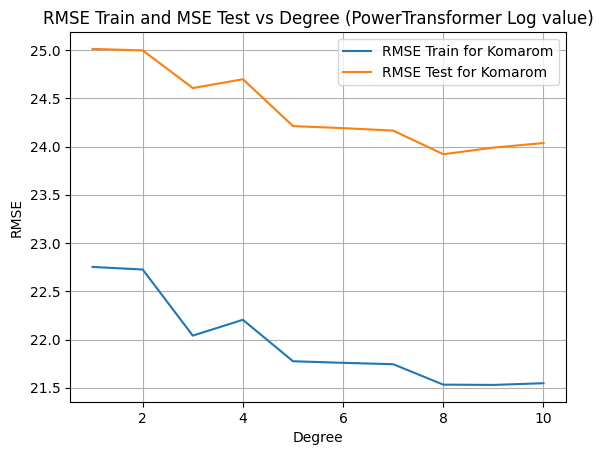

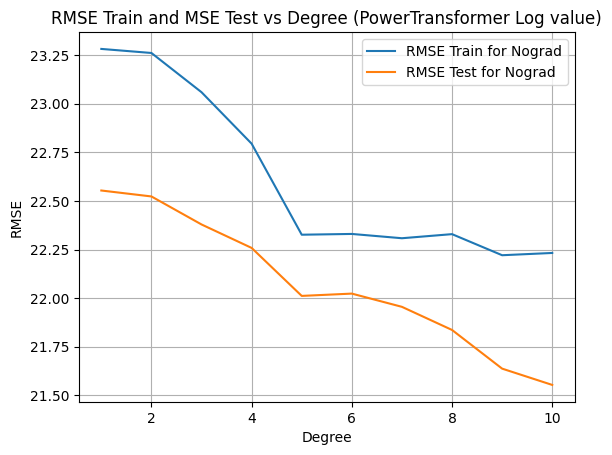

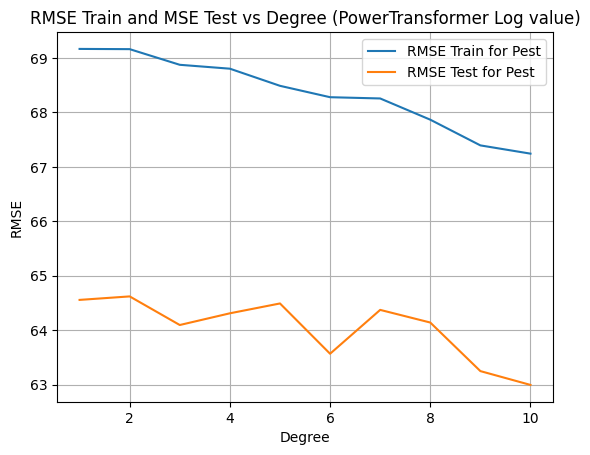

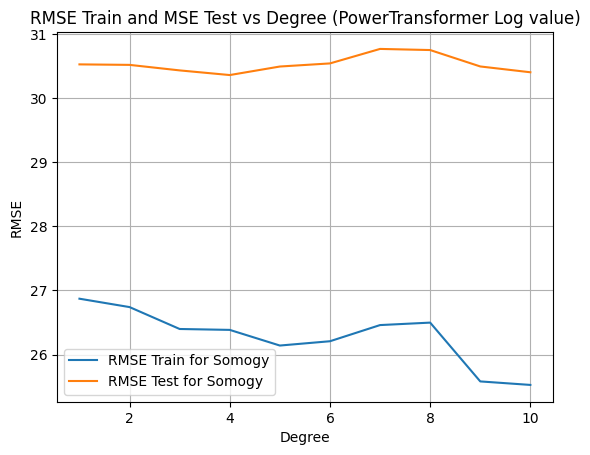

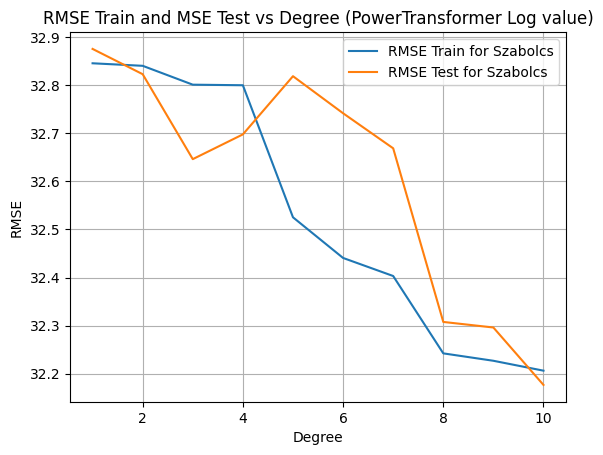

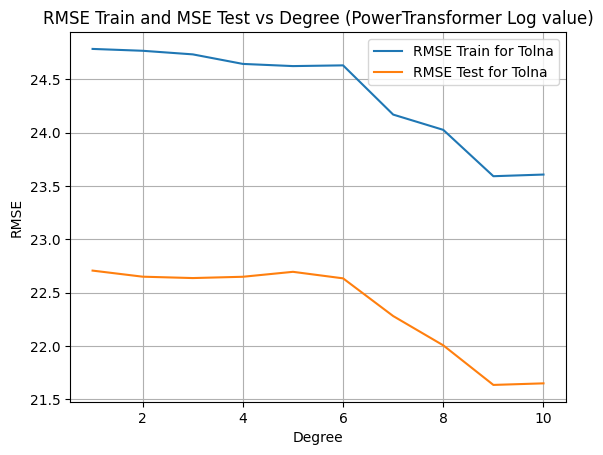

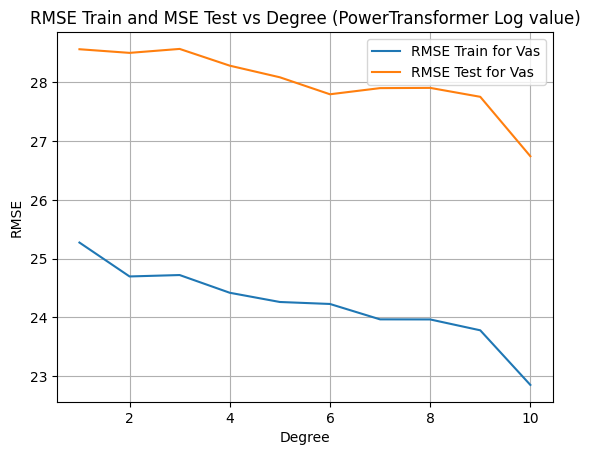

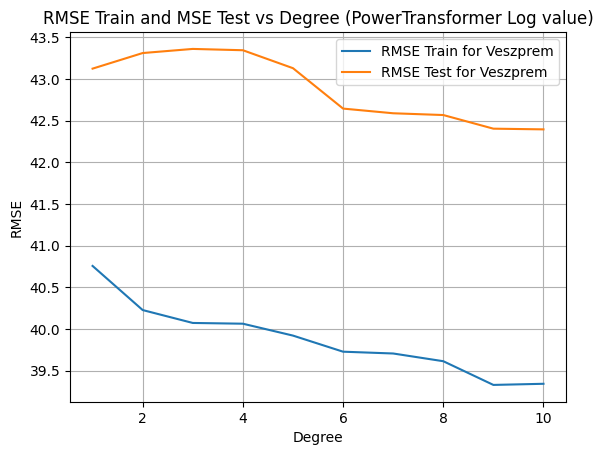

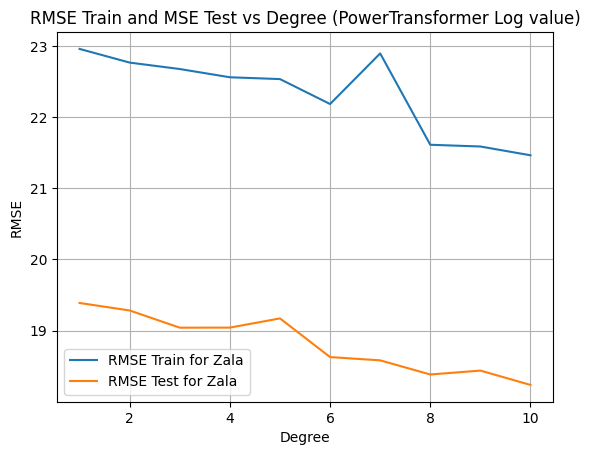

In [607]:
degrees = range(1, 11)
rmse_test_pow_log = []
rmse_train_pow_log = []

best_degrees_pow_log = []

for county in county_list:

    rmse_test_county_pow_log = []
    rmse_train_county_pow_log = []  

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        y += 1

        # Logarithmic transformation of y
        y_log = np.log(y)

        # Normalize the target variable
        y_scaled_pow_log = scaler_pow.fit_transform(y_log.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_pow_log, y_test_pow_log = train_test_split(y_scaled_pow_log, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_pow = poly_features.fit_transform(x_train_pow)
        x_test_poly_pow = poly_features.transform(x_test_pow)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_pow, y_train_pow_log)

        # Predict y values for train and test sets
        y_train_pred_pow_log = model.predict(x_train_poly_pow)
        y_test_pred_pow_log = model.predict(x_test_poly_pow)

        # Performing inverse transform so that we have uniform scaling for errors
        y_train_pred_pow_log = scaler_pow.inverse_transform(y_train_pred_pow_log.reshape(-1, 1))
        y_train_pow_log = scaler_pow.inverse_transform(y_train_pow_log.reshape(-1, 1))

        y_test_pred_pow_log = scaler_pow.inverse_transform(y_test_pred_pow_log.reshape(-1, 1))
        y_test_pow_log = scaler_pow.inverse_transform(y_test_pow_log.reshape(-1, 1))

        # Detransforming y_pred_min and y_test_min
        y_train_pred_pow_log = np.exp(y_train_pred_pow_log)
        y_test_pred_pow_log = np.exp(y_test_pred_pow_log)

        y_train_pow_log = np.exp(y_train_pow_log)
        y_test_pow_log = np.exp(y_test_pow_log)

        # calculating errors
        rmse_train_county_pow_log.append(rmse(y_train_pred_pow_log, y_train_pow_log))
        rmse_test_county_pow_log.append(rmse(y_test_pred_pow_log, y_test_pow_log))
        
    rmse_test_pow_log.append(np.min(rmse_test_county_pow_log))
    rmse_train_pow_log.append(rmse_test_county_min_log[np.argmin(rmse_test_county_pow_log)])
    best_degrees_pow_log.append(np.argmin(rmse_test_county_pow_log) + 1)

    plt.plot(degrees, rmse_train_county_pow_log, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_pow_log, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (PowerTransformer Log value)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [608]:
new_df_list = {'County': county_list,
               'Best degree (MinMax - No Log)': best_degrees_min,
               'RMSE (MinMax - No Log)': rmse_test_min,
               'Best degree (MinMax - Log)': best_degrees_min_log,
               'RMSE (MinMax - Log)': rmse_test_min_log,
               'Best degree (Power - No Log)': best_degrees_pow,
               'RMSE (Power - No Log)': rmse_test_pow,
               'Best degree (Power - Log)': best_degrees_pow_log,
               'RMSE (Power - Log)': rmse_test_pow_log,
               }

county_with_best_degree = pd.DataFrame(new_df_list)

county_with_best_degree.set_index('County')

Best degree (MinMax - No Log)  RMSE (MinMax - No Log)   
County                                                            
BUDAPEST                              3               64.668641  \
BARANYA                              10               33.361206   
BACS                                  4               32.846310   
BEKES                                10               27.992082   
BORSOD                                8               48.221942   
CSONGRAD                              6               27.218172   
FEJER                                 8               30.071276   
GYOR                                  6               32.286276   
HAJDU                                 7               40.519456   
HEVES                                10               29.200780   
JASZ                                  4               35.018834   
KOMAROM                               4               23.119952   
NOGRAD                                9               19.686460   
PEST                                  9               59.422799   
SOMOGY                               10               28.030444   
SZABOLCS                             10               30.815754   
TOLNA                                 9               20.516640   
VAS                                   9               25.067647   
VESZPREM                             10               38.712895   
ZALA                                  5               18.010758   

          Best degree (MinMax - Log)  RMSE (MinMax - Log)   
County                                                      
BUDAPEST                           5            70.408512  \
BARANYA                            9            35.954540   
BACS                              10            35.058994   
BEKES                              5            28.860934   
BORSOD                             9            51.883247   
CSONGRAD                           9            27.603533   
FEJER                             10            32.884740   
GYOR                               6            35.854001   
HAJDU                             10            42.326139   
HEVES                             10            31.099895   
JASZ                               9            37.385416   
KOMAROM                            9            24.095542   
NOGRAD                            10            21.266501   
PEST                              10            66.434222   
SOMOGY                             7            30.508529   
SZABOLCS                           9            32.025014   
TOLNA                             10            21.033618   
VAS                                9            26.576378   
VESZPREM                          10            42.011422   
ZALA                              10            18.079137   

          Best degree (Power - No Log)  RMSE (Power - No Log)   
County                                                          
BUDAPEST                             6              65.707070  \
BARANYA                             10              35.553141   
BACS                                10              34.324584   
BEKES                                4              29.508604   
BORSOD                               9              51.160992   
CSONGRAD                            10              27.604981   
FEJER                               10              32.742678   
GYOR                                 9              34.316566   
HAJDU                                6              41.833186   
HEVES                                8              31.058742   
JASZ                                 9              36.633951   
KOMAROM                              8              23.931284   
NOGRAD                              10              21.605728   
PEST                                10              62.893272   
SOMOGY                               4              30.309016   
SZABOLCS                            10              32.201868   
TOLNA                 

In [609]:
print(f"Mean RMSE for:\nMinMax Scaler with no log transform = {np.mean(new_df_list['RMSE (MinMax - No Log)'])}\nMinMax Scaler with log transform = {np.mean(new_df_list['RMSE (MinMax - Log)'])}")
print(f"PowerTransformer with no log transform = {np.mean(new_df_list['RMSE (Power - No Log)'])}\nPowerTransformer with log transform = {np.mean(new_df_list['RMSE (Power - Log)'])}")

Mean RMSE for:
MinMax Scaler with no log transform = 33.23941624689928
MinMax Scaler with log transform = 35.56751563426327
PowerTransformer with no log transform = 35.025693853325535
PowerTransformer with log transform = 35.03063835533989


In [610]:
model_mean_rmse['Polynomial Regression - MinMaxScaler (no log)'] = np.mean(new_df_list['RMSE (MinMax - No Log)'])
model_mean_rmse['Polynomial Regression - MinMaxScaler (log)'] = np.mean(new_df_list['RMSE (MinMax - Log)'])
model_mean_rmse['Polynomial Regression - PowerTransformer (no log)'] = np.mean(new_df_list['RMSE (Power - No Log)'])
model_mean_rmse['Polynomial Regression - PowerTransformer (log)'] = np.mean(new_df_list['RMSE (Power - Log)'])

model_mean_rmse

{'Polynomial Regression - MinMaxScaler (no log)': 33.23941624689928,
 'Polynomial Regression - MinMaxScaler (log)': 35.56751563426327,
 'Polynomial Regression - PowerTransformer (no log)': 35.025693853325535,
 'Polynomial Regression - PowerTransformer (log)': 35.03063835533989}

SARIMA MODEL

In [552]:
data_diff = df.drop('Week', axis=1)

data_diff.head(2)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   

   VESZPREM  ZALA  
0        87    68  
1        68    26  

[2 rows x 21 columns]

In [553]:
data_diff['Date'] = pd.to_datetime(data_diff['Date'], format='mixed')

data_diff.head(1)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0 2005-03-01       168       79    30    173     169        42    136   120  \

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \

   VESZPREM  ZALA  
0        87    68  

[1 rows x 21 columns]

In [554]:
#data_diff = data_diff[['Date', 'BUDAPEST']].set_index('Date')

data_diff.tail()

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
517 2014-01-12        95       12    41      6      39         0     16    15  \
518 2014-08-12        43       39    31     10      34         3      2    30   
519 2014-12-15        35        7    15      0       0         0      7     7   
520 2014-12-22        30       23     8      0      11         4      1     9   
521 2014-12-29       259       42    49     32      38        15     11    98   

     HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
517     14  ...    56        7      13   122       4        23      4   11  \
518     25  ...    34       20      18    70      36         5     23   22   
519      4  ...    30       36       4    72       5        21     14    0   
520     10  ...    27       17      21    12       5        17      1    1   
521     61  ...   112       61      53   256      45        39     27   11   

     VESZPREM  ZALA  
517       110    10  
518        63     9  
519        17    10  
520        83     2  
521       103    25  

[5 rows x 21 columns]

In [555]:
dates = df['Date'].to_list()

len(dates)

522

In [556]:
# Convert date strings to datetime objects
parsed_dates = pd.to_datetime(dates, format='%d/%m/%Y')

# Create a DatetimeIndex using the parsed dates
index = pd.DatetimeIndex(parsed_dates)

index

DatetimeIndex(['2005-01-03', '2005-01-10', '2005-01-17', '2005-01-24',
               '2005-01-31', '2005-02-07', '2005-02-14', '2005-02-21',
               '2005-02-28', '2005-03-07',
               ...
               '2014-10-27', '2014-11-03', '2014-11-10', '2014-11-17',
               '2014-11-24', '2014-12-01', '2014-12-08', '2014-12-15',
               '2014-12-22', '2014-12-29'],
              dtype='datetime64[ns]', length=522, freq=None)

In [557]:
data_diff['Date'] = index

data_diff.head(1)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0 2005-01-03       168       79    30    173     169        42    136   120  \

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \

   VESZPREM  ZALA  
0        87    68  

[1 rows x 21 columns]

In [558]:
data_diff = data_diff.set_index('Date')

data_diff.head(1)

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
Date                                                                        
2005-01-03       168       79    30    173     169        42    136   120  \

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
Date                                                                      
2005-01-03    162     36   130       57       2   178      66        64  \

            TOLNA  VAS  VESZPREM  ZALA  
Date                                    
2005-01-03     11   29        87    68

In [559]:
data_diff['BUDAPEST']

Date
2005-01-03    168
2005-01-10    157
2005-01-17     96
2005-01-24    163
2005-01-31    122
             ... 
2014-12-01     95
2014-12-08     43
2014-12-15     35
2014-12-22     30
2014-12-29    259
Name: BUDAPEST, Length: 522, dtype: int64

In [560]:
warnings.filterwarnings("ignore")

rmse_sarimax = []
# Apply differencing to make the data stationary
data_diff = data_diff.diff().dropna()

# Define the SARIMA model parameters
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 0, 1, 12)  # (P, D, Q, s)

for county in county_list:
    # Split the data into train and test sets
    train_data, test_data = train_test_split(data_diff[county], test_size=0.2, random_state=101)

    # Fit the SARIMA model
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Forecast future values
    forecast = model_fit.forecast(steps=len(test_data))

    # Obtain the original scale forecast by applying inverse differencing
    forecast_original = forecast.cumsum() + train_data.iloc[-1]

    # Calculate the mean squared error (MSE) for the test set
    rmse_sarimax_county = rmse(test_data, forecast_original)
    print(f"RMSE for {county}:", rmse_sarimax_county)

    rmse_sarimax.append(rmse_sarimax_county)

warnings.filterwarnings("default")

RMSE for BUDAPEST: 247.64254038896672
RMSE for BARANYA: 49.76126074029662
RMSE for BACS: 110.10794159731452
RMSE for BEKES: 50.99077194475842
RMSE for BORSOD: 228.37449686064508
RMSE for CSONGRAD: 48.75118705860231
RMSE for FEJER: 66.10973193984535
RMSE for GYOR: 37.259012966751385
RMSE for HAJDU: 109.89331164637359
RMSE for HEVES: 150.18672972374773
RMSE for JASZ: 70.35091110405644
RMSE for KOMAROM: 84.99443668858314
RMSE for NOGRAD: 120.87993588000947
RMSE for PEST: 134.28659222765558
RMSE for SOMOGY: 47.55492435674258
RMSE for SZABOLCS: 102.97215048715407
RMSE for TOLNA: 18.022131973830927
RMSE for VAS: 63.46742574446888
RMSE for VESZPREM: 55.63577080110845
RMSE for ZALA: 47.50242976530495


In [561]:
model_mean_rmse['SARIMA Model'] = np.mean(rmse_sarimax)

XGBOOST

In [562]:
# Create lag features for each county
def create_lag_features(data, lag):
    lagged_data = data.copy()
    for col in data.columns:
        for i in range(1, lag+1):
            lagged_data[f'lag_{i}_{col}'] = data[col].shift(i)
            lagged_data[f'lag_{i}_{col}'].fillna(method='backfill', inplace=True)  # Use backfill to fill NaN values
    return lagged_data

In [563]:
data = df.drop('Week', axis=1)

data.head()

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   
2  17/01/2005        96       44    31     86      93        30     93    84   
3  24/01/2005       163       49    43    126      46        39     52   114   
4  31/01/2005       122       78    53     87     103        34     95   131   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   
3    107  ...    63       54      14   107      66        50     25   21   
4    172  ...    61       49      11   124      63        56      7   47   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  
3        43    31  
4        85    60  

[5 rows x 21 columns]

In [564]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data = data.set_index('Date')

data.head()

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
Date                                                                        
2005-01-03       168       79    30    173     169        42    136   120  \
2005-01-10       157       60    30     92     200        53     51    70   
2005-01-17        96       44    31     86      93        30     93    84   
2005-01-24       163       49    43    126      46        39     52   114   
2005-01-31       122       78    53     87     103        34     95   131   

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
Date                                                                      
2005-01-03    162     36   130       57       2   178      66        64  \
2005-01-10     84     28    80       50      29   141      48        29   
2005-01-17    191     51    64       46       4   157      33        33   
2005-01-24    107     42    63       54      14   107      66        50   
2005-01-31    172     40    61       49      11   124      63        56   

            TOLNA  VAS  VESZPREM  ZALA  
Date                                    
2005-01-03     11   29        87    68  
2005-01-10     58   53        68    26  
2005-01-17     24   18        62    44  
2005-01-24     25   21        43    31  
2005-01-31      7   47        85    60

In [565]:
model = XGBRegressor()

In [566]:
model.learning_rate = 0.00001  # Learning rate
model.max_depth = 100  # Maximum depth of each tree
model.n_estimators = 500  # Number of trees (boosting rounds)
model.reg_alpha = 0.05  # L1 regularization term
model.reg_lambda = 0.1  # L2 regularization term

In [567]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=101)

lag = 3  # Adjust the lag as per your requirements
train_lagged = create_lag_features(train_data, lag)
test_lagged = create_lag_features(test_data, lag)

# Prepare the input features and target variables
X_train, y_train = train_lagged.dropna().drop(data.columns, axis=1), train_lagged.dropna()[data.columns]
X_test, y_test = test_lagged.dropna().drop(data.columns, axis=1), test_lagged.dropna()[data.columns]

y_test

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
Date                                                                        
2011-02-21       228       46    32    102     164        72     54    67  \
2007-06-11       210       75    65     80     129        47     13    57   
2010-04-05       160       80   108     17      52        11     34    75   
2005-10-03        17        4     6     10      34         1     10     1   
2010-07-05        93       44    48     21      51        13     29    54   
...              ...      ...   ...    ...     ...       ...    ...   ...   
2013-12-09        63       30    30     11      81        16     38    40   
2009-06-29        65       17    42     15      20        36     12    52   
2007-04-02       166       68    69     66     138        21     66    90   
2007-12-31       183       41    57    138     126         7     42    32   
2008-04-14       122       42    51     58     119        41    101    73   

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
Date                                                                      
2011-02-21     55     22    82       61      14   189      24       102  \
2007-06-11    120     40    11       56      59   125      25        14   
2010-04-05     54     15    52       52      11   143      23        22   
2005-10-03     21      7     8       21       4    27       6         3   
2010-07-05     21     20    71       20       8    70      37        40   
...           ...    ...   ...      ...     ...   ...     ...       ...   
2013-12-09     37     21    12       11       6    29       5        18   
2009-06-29     84     53    42       21      21    72      17        16   
2007-04-02     83     86    54       70      30   209      37        26   
2007-12-31     22     11    35       78      21   167      50        69   
2008-04-14     75     23   104       31      37   156      10        60   

            TOLNA  VAS  VESZPREM  ZALA  
Date                                    
2011-02-21     43   30        98    35  
2007-06-11     22    7        32    16  
2010-04-05     35   17        39     6  
2005-10-03      1   17        20    13  
2010-07-05     23    7        50    24  
...           ...  ...       ...   ...  
2013-12-09      0   44        11     2  
2009-06-29     12   40         7    51  
2007-04-02     21   39       107    27  
2007-12-31     10    3        37    12  
2008-04-14     15    7        47    22  

[105 rows x 20 columns]

In [568]:
# data = pd.DataFrame(scaler_pow.fit_transform(data), columns=data.columns)

X_train = scaler_pow.fit_transform(X_train)
X_test = scaler_pow.fit_transform(X_test)

# Train the XGBoost model for each county and calculate RMSE
rmse_score = {}
for county in data.columns:   

    Y_train = y_train[county] 
    Y_test = np.array(y_test[county].to_list())

    Y_train = scaler_pow.fit_transform(np.array(Y_train).reshape(-1, 1))
    Y_test = scaler_pow.fit_transform(Y_test.reshape(-1, 1))

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    Y_test = scaler_pow.inverse_transform(Y_test.reshape(-1, 1))
    y_pred = scaler_pow.inverse_transform(y_pred.reshape(-1, 1))

    rmse_county = rmse(y_test[county], y_pred)
    rmse_score[county] = rmse_county


# Print overall RMSE score for each county
for county, error in rmse_score.items():
    print(f"County: {county}, RMSE: {error}")

County: BUDAPEST, RMSE: 69.08843516753554
County: BARANYA, RMSE: 35.455283406823526
County: BACS, RMSE: 34.09270957797778
County: BEKES, RMSE: 31.262316449442753
County: BORSOD, RMSE: 50.48727478609601
County: CSONGRAD, RMSE: 27.659471585265056
County: FEJER, RMSE: 33.36000538710094
County: GYOR, RMSE: 36.54209827332018
County: HAJDU, RMSE: 45.180575638821104
County: HEVES, RMSE: 30.934371549691313
County: JASZ, RMSE: 37.755542031548906
County: KOMAROM, RMSE: 25.167954634691736
County: NOGRAD, RMSE: 21.243395370216064
County: PEST, RMSE: 66.08084929321386
County: SOMOGY, RMSE: 29.02005440193281
County: SZABOLCS, RMSE: 32.23503532293289
County: TOLNA, RMSE: 21.51639836808641
County: VAS, RMSE: 27.381687786233325
County: VESZPREM, RMSE: 41.6273435076803
County: ZALA, RMSE: 19.006567422621195


In [569]:
rmse_xg = []
for county, score in rmse_score.items():
    rmse_xg.append(score)

model_mean_rmse['XGBOOST Model'] = np.mean(rmse_xg)

np.mean(rmse_xg)

35.75486849806158

Prophet

In [570]:
# Load the CSV file
data = df

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.rename(columns={'Date': 'ds'}, inplace=True)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=101)

rmse_proph = {}

for county in county_list:
    # Prepare the target variable
    target_col = county  # Choose the county for analysis
    train_target = train_data[['ds', target_col]].rename(columns={'ds': 'ds', target_col: 'y'})

    # Train the Prophet model
    model = Prophet()
    model.add_seasonality(name='weekly', period=7, fourier_order=10, mode='additive')
    model.fit(train_target)

    # Generate future dates for prediction
    future = model.make_future_dataframe(periods=len(test_data), freq='W-MON')

    # Perform predictions
    forecast = model.predict(future)

    # Extract the predicted values
    y_pred = forecast['yhat'].tail(len(test_data))

    # Prepare the true values for evaluation
    y_true = test_data[[target_col]].reset_index(drop=True)

    # Calculate RMSE
    rmse_proph[county] = rmse(y_true, y_pred)

19:46:21 - cmdstanpy - INFO - Chain [1] start processing
19:46:21 - cmdstanpy - INFO - Chain [1] done processing
19:46:21 - cmdstanpy - INFO - Chain [1] start processing
19:46:22 - cmdstanpy - INFO - Chain [1] done processing
19:46:22 - cmdstanpy - INFO - Chain [1] start processing
19:46:22 - cmdstanpy - INFO - Chain [1] done processing
19:46:23 - cmdstanpy - INFO - Chain [1] start processing
19:46:23 - cmdstanpy - INFO - Chain [1] done processing
19:46:23 - cmdstanpy - INFO - Chain [1] start processing
19:46:23 - cmdstanpy - INFO - Chain [1] done processing
19:46:24 - cmdstanpy - INFO - Chain [1] start processing
19:46:24 - cmdstanpy - INFO - Chain [1] done processing
19:46:24 - cmdstanpy - INFO - Chain [1] start processing
19:46:24 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1]

In [571]:
for county, error in rmse_proph.items():
    print(f"County: {county}, RMSE: {error}")

County: BUDAPEST, RMSE: 90.10915323377147
County: BARANYA, RMSE: 43.13151913578057
County: BACS, RMSE: 42.343926747368215
County: BEKES, RMSE: 39.05752645189171
County: BORSOD, RMSE: 60.15046129374483
County: CSONGRAD, RMSE: 38.54766090203415
County: FEJER, RMSE: 40.032722950117616
County: GYOR, RMSE: 47.74239121743382
County: HAJDU, RMSE: 56.12066175438987
County: HEVES, RMSE: 35.80905805515126
County: JASZ, RMSE: 43.7362356098024
County: KOMAROM, RMSE: 34.26617554602166
County: NOGRAD, RMSE: 26.399752154901467
County: PEST, RMSE: 85.84130025683721
County: SOMOGY, RMSE: 36.37654566979274
County: SZABOLCS, RMSE: 37.450883186442574
County: TOLNA, RMSE: 25.77180748236117
County: VAS, RMSE: 30.756581880192858
County: VESZPREM, RMSE: 54.17879340959771
County: ZALA, RMSE: 24.44836985832191


In [572]:
rmse_prophet = []

for county, score in rmse_proph.items():
    rmse_prophet.append(score)

model_mean_rmse['Prophet Model'] = np.mean(rmse_prophet)

np.mean(rmse_prophet)

44.61357633979776

RNN

In [573]:
data = df

data.columns

Index(['Week', 'ds', 'BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD',
       'CSONGRAD', 'FEJER', 'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM',
       'NOGRAD', 'PEST', 'SOMOGY', 'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM',
       'ZALA'],
      dtype='object')

In [574]:
data = data.drop('Week', axis=1).set_index('ds')
data = data.asfreq('W-MON')

data

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
ds                                                                          
2005-01-03       168       79    30    173     169        42    136   120  \
2005-01-10       157       60    30     92     200        53     51    70   
2005-01-17        96       44    31     86      93        30     93    84   
2005-01-24       163       49    43    126      46        39     52   114   
2005-01-31       122       78    53     87     103        34     95   131   
...              ...      ...   ...    ...     ...       ...    ...   ...   
2014-12-01        95       12    41      6      39         0     16    15   
2014-12-08        43       39    31     10      34         3      2    30   
2014-12-15        35        7    15      0       0         0      7     7   
2014-12-22        30       23     8      0      11         4      1     9   
2014-12-29       259       42    49     32      38        15     11    98   

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
ds                                                                        
2005-01-03    162     36   130       57       2   178      66        64  \
2005-01-10     84     28    80       50      29   141      48        29   
2005-01-17    191     51    64       46       4   157      33        33   
2005-01-24    107     42    63       54      14   107      66        50   
2005-01-31    172     40    61       49      11   124      63        56   
...           ...    ...   ...      ...     ...   ...     ...       ...   
2014-12-01     14     10    56        7      13   122       4        23   
2014-12-08     25     19    34       20      18    70      36         5   
2014-12-15      4      2    30       36       4    72       5        21   
2014-12-22     10     17    27       17      21    12       5        17   
2014-12-29     61     38   112       61      53   256      45        39   

            TOLNA  VAS  VESZPREM  ZALA  
ds                                      
2005-01-03     11   29        87    68  
2005-01-10     58   53        68    26  
2005-01-17     24   18        62    44  
2005-01-24     25   21        43    31  
2005-01-31      7   47        85    60  
...           ...  ...       ...   ...  
2014-12-01      4   11       110    10  
2014-12-08     23   22        63     9  
2014-12-15     14    0        17    10  
2014-12-22      1    1        83     2  
2014-12-29     27   11       103    25  

[522 rows x 20 columns]

In [575]:
rmse_rnn = {}

for county in county_list:
    print(county)
    # Preprocess the data
    data_rnn = data[county].values  # Extract the values as a NumPy array
    data_rnn = data_rnn.reshape(-1, 1)  # Reshape to a 2D array (number of samples, 1)

    # Split the data into training and testing sets
    train_data, test_data = train_test_split(data_rnn, test_size=0.2, random_state=101)

    # Create sequences of input/output pairs for training
    sequence_length = 15  # Number of time steps to look back
    X_train, y_train = [], []
    for i in range(len(train_data) - sequence_length):
        X_train.append(train_data[i:i+sequence_length])
        y_train.append(train_data[i+sequence_length])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape the input data to match the requirements of LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build the RNN model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
    model.add(LSTM(units=100, activation='relu', return_sequences=True))
    model.add(LSTM(units=100, activation='relu', return_sequences=False))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Generate predictions for the test data
    X_test, y_test = [], []
    for i in range(len(test_data) - sequence_length):
        X_test.append(test_data[i:i+sequence_length])
        y_test.append(test_data[i+sequence_length])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predictions = model.predict(X_test)

    # Evaluate the model
    rmse_rnn[county] = rmse(predictions, y_test)

BUDAPEST
Epoch 1/50
13/13 [==============================] - 8s 191ms/step - loss: 10267.9834
Epoch 2/50
13/13 [==============================] - 2s 163ms/step - loss: 7368.7188
Epoch 3/50
13/13 [==============================] - 1s 92ms/step - loss: 7166.6021
Epoch 4/50
13/13 [==============================] - 2s 120ms/step - loss: 7010.2690
Epoch 5/50
13/13 [==============================] - 2s 180ms/step - loss: 7017.7222
Epoch 6/50
13/13 [==============================] - 2s 141ms/step - loss: 6904.3975
Epoch 7/50
13/13 [==============================] - 1s 76ms/step - loss: 7316.0459
Epoch 8/50
13/13 [==============================] - 1s 75ms/step - loss: 6701.8940
Epoch 9/50
13/13 [==============================] - 1s 75ms/step - loss: 6672.3477
Epoch 10/50
13/13 [==============================] - 1s 88ms/step - loss: 6472.1812
Epoch 11/50
13/13 [==============================] - 1s 93ms/step - loss: 6576.9863
Epoch 12/50
13/13 [==============================] - 1s 83ms/step - lo

In [576]:
rmse_rnn

{'BUDAPEST': 70.01150675139002,
 'BARANYA': 35.63096738478406,
 'BACS': 39.84592966490675,
 'BEKES': 30.977488781580526,
 'BORSOD': 60.146810365489834,
 'CSONGRAD': 29.72097283670268,
 'FEJER': 41.14772758509057,
 'GYOR': 39.034041342851495,
 'HAJDU': 52.4484077878596,
 'HEVES': 43.726051451067434,
 'JASZ': 45.47657020083791,
 'KOMAROM': 34.21452607371972,
 'NOGRAD': 29.91778468397633,
 'PEST': 65.11822289441183,
 'SOMOGY': 33.613771739233215,
 'SZABOLCS': 33.366352747074664,
 'TOLNA': 27.88348981552402,
 'VAS': 29.939780497085362,
 'VESZPREM': 47.45830657099621,
 'ZALA': 26.98827829957719}

In [577]:
rmse_r = []

for county, score in rmse_rnn.items():
    rmse_r.append(score)

model_mean_rmse['RNN Model'] = np.mean(rmse_r)

np.mean(rmse_r)

40.833349373707975

In [578]:
model_mean_rmse

{'Polynomial Regression - MinMaxScaler (no log)': 33.23941624689928,
 'Polynomial Regression - MinMaxScaler (log)': 35.56751563426327,
 'Polynomial Regression - PowerTransformer (no log)': 35.025693853325535,
 'Polynomial Regression - PowerTransformer (log)': 35.03063835533989,
 'SARIMA Model': 92.23718469481082,
 'XGBOOST Model': 35.75486849806158,
 'Prophet Model': 44.61357633979776,
 'RNN Model': 40.833349373707975}

Thus, the average root mean squared error is lowest for polynomial regression using MinMax scaler without log tranformation. Hence, we will be predicting the future cases using it.

Predicting cases:

In [611]:
predictions_df = pd.DataFrame({'Week': np.arange(x.max() + 1, x.max() + 101)})

predictions_df.head(2)

Week
0   523
1   524

In [612]:
best_degrees_min

[3, 10, 4, 10, 8, 6, 8, 6, 7, 10, 4, 4, 9, 9, 10, 10, 9, 9, 10, 5]

In [613]:
df.head()

Week        Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   
0     1  03/01/2005       168       79    30    173     169        42    136  \
1     2  10/01/2005       157       60    30     92     200        53     51   
2     3  17/01/2005        96       44    31     86      93        30     93   
3     4  24/01/2005       163       49    43    126      46        39     52   
4     5  31/01/2005       122       78    53     87     103        34     95   

   GYOR  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0   120  ...   130       57       2   178      66        64     11   29  \
1    70  ...    80       50      29   141      48        29     58   53   
2    84  ...    64       46       4   157      33        33     24   18   
3   114  ...    63       54      14   107      66        50     25   21   
4   131  ...    61       49      11   124      63        56      7   47   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  
3        43    31  
4        85    60  

[5 rows x 22 columns]

In [614]:
for i in range(len(county_list)):
    # Extract the target variable for the current county
    y = df[county_list[i]].values

    # Normalize the target variable
    y_scaled = scaler_min.fit_transform(y.reshape(-1, 1)).flatten()

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=best_degrees_min[i])
    x_poly = poly_features.fit_transform(x_scaled_min)

    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y_scaled)

    # Predict the next 100 weeks
    future_weeks = np.arange(x_scaled_min.max() + 1, x_scaled_min.max() + 101)
    future_x = scaler.transform(future_weeks.reshape(-1, 1))
    future_x_poly = poly_features.transform(future_x)
    future_y_scaled = model.predict(future_x_poly)

    # Denormalize the predicted values
    future_y = scaler.inverse_transform(future_y_scaled.reshape(-1, 1)).flatten()

    # Add predictions to the dataframe
    predictions_df[county_list[i]] = future_y

predictions_df = predictions_df.round()

In [615]:
print("Predictions for next 100 weeks can be seen as follows:")
predictions_df

Predictions for next 100 weeks can be seen as follows:


Week  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   GYOR   
0    523      49.0     73.0  48.0  109.0    71.0      31.0  108.0  131.0  \
1    524      48.0     68.0  47.0   99.0    66.0      34.0   98.0  121.0   
2    525      48.0     63.0  46.0   90.0    61.0      36.0   88.0  111.0   
3    526      48.0     58.0  45.0   80.0    57.0      37.0   79.0  102.0   
4    527      48.0     53.0  44.0   71.0    53.0      39.0   71.0   94.0   
..   ...       ...      ...   ...    ...     ...       ...    ...    ...   
95   618      42.0     45.0  29.0   17.0    25.0      35.0   29.0   37.0   
96   619      42.0     45.0  29.0   18.0    25.0      35.0   29.0   36.0   
97   620      42.0     46.0  29.0   18.0    25.0      35.0   30.0   36.0   
98   621      42.0     46.0  29.0   19.0    25.0      35.0   31.0   36.0   
99   622      42.0     46.0  29.0   19.0    25.0      35.0   31.0   35.0   

    HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA   VAS   
0   111.0  ...  84.0     80.0    29.0  65.0    78.0      58.0   31.0  62.0  \
1   101.0  ...  81.0     77.0    27.0  58.0    64.0      53.0   26.0  59.0   
2    92.0  ...  78.0     75.0    25.0  53.0    54.0      49.0   24.0  56.0   
3    84.0  ...  75.0     72.0    24.0  49.0    47.0      46.0   22.0  55.0   
4    76.0  ...  72.0     70.0    24.0  45.0    42.0      44.0   22.0  54.0   
..    ...  ...   ...      ...     ...   ...     ...       ...    ...   ...   
95   35.0  ...  40.0     36.0    26.0  42.0    29.0      19.0   41.0  34.0   
96   35.0  ...  40.0     36.0    26.0  43.0    29.0      19.0   40.0  33.0   
97   34.0  ...  40.0     36.0    25.0  43.0    29.0      19.0   39.0  32.0   
98   34.0  ...  40.0     36.0    25.0  44.0    28.0      20.0   38.0  31.0   
99   33.0  ...  40.0     36.0    24.0  44.0    28.0      20.0   37.0  29.0   

    VESZPREM  ZALA  
0       71.0  33.0  
1       61.0  33.0  
2       54.0  34.0  
3       49.0  34.0  
4       46.0  34.0  
..       ...   ...  
95      30.0  16.0  
96      30.0  16.0  
97      31.0  16.0  
98      31.0  17.0  
99      32.0  17.0  

[100 rows x 21 columns]

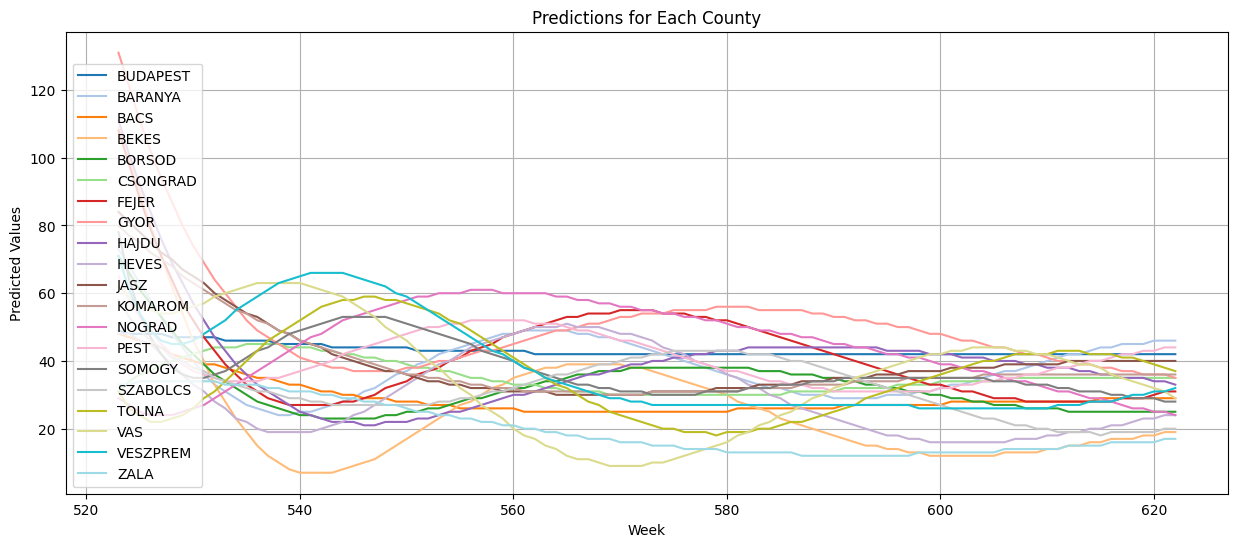

In [616]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Generate 20 different colors

# Set the figsize
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the predictions for each county with different colors
for i, col in enumerate(predictions_df.columns[1:]):
    plt.plot(predictions_df['Week'], predictions_df[col], label=col, color=colors[i])

plt.xlabel('Week')
plt.ylabel('Predicted Values')
plt.title('Predictions for Each County')
plt.legend()
plt.grid(True)
plt.show()

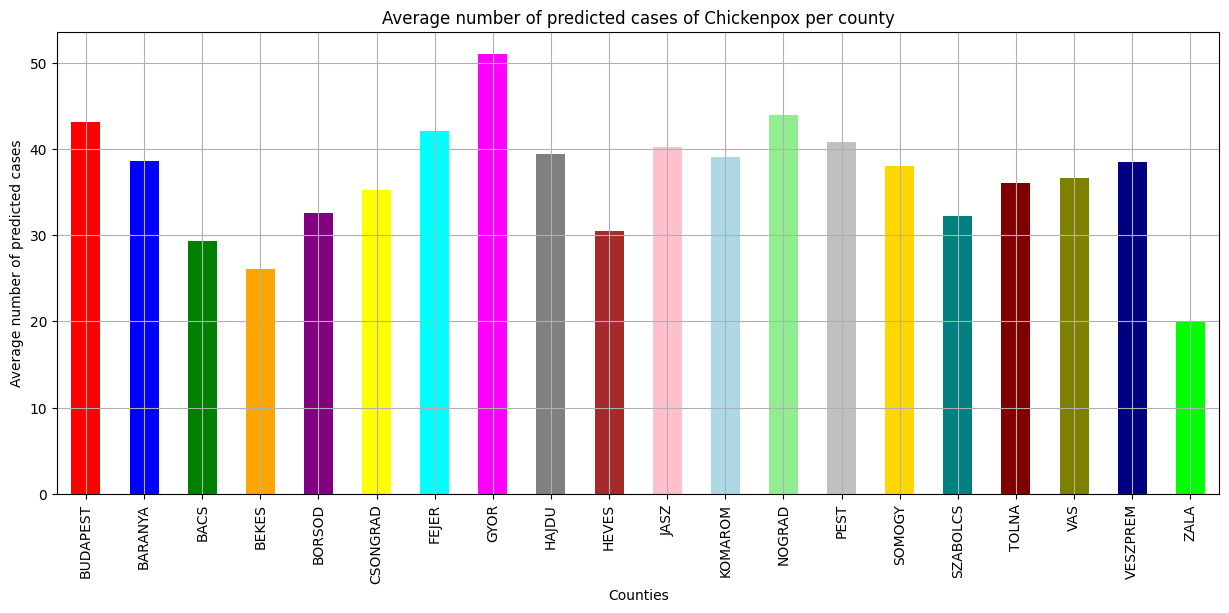

In [617]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'gray', 'brown','pink', 'lightblue', 'lightgreen', 
          'silver', 'gold', 'teal', 'maroon', 'olive', 'navy', 'lime']
 
predictions_df[county_list].mean().plot(kind='bar', color=colors, figsize=(15, 6), grid=True)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.xlabel('Counties')
plt.ylabel('Average number of predicted cases')
plt.title('Average number of predicted cases of Chickenpox per county')

plt.show()

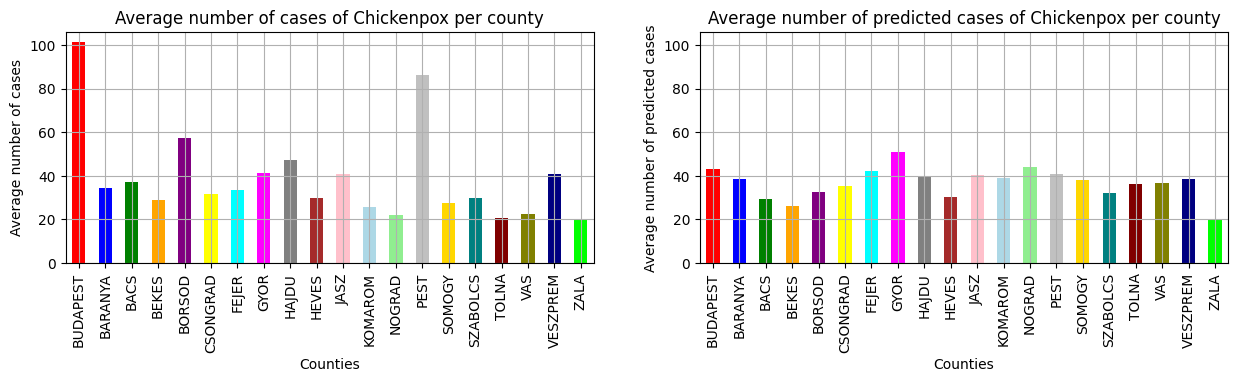

In [618]:
# Define the colors for the plots
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'gray', 'brown',
          'pink', 'lightblue', 'lightgreen', 'silver', 'gold', 'teal', 'maroon', 'olive', 'navy', 'lime']

# Create subplots with a 1x2 grid layout
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

avg_cases = df[county_list].mean()

avg_predicted_cases = predictions_df[county_list].mean()

if avg_cases.max() > avg_predicted_cases.max():
    max_cases = avg_cases.max()
else:
    max_cases = avg_predicted_cases.max()

# Plot the average number of cases
avg_cases.plot(kind='bar', color=colors, ax=axes[0], grid=True)
axes[0].set_xticklabels(avg_cases.index, rotation=90)
axes[0].set_xlabel('Counties')
axes[0].set_ylabel('Average number of cases')
axes[0].set_title('Average number of cases of Chickenpox per county')
axes[0].set_ylim([0, np.round(max_cases + 5)])  # Set y-axis limits

# Plot the average number of predicted cases
avg_predicted_cases.plot(kind='bar', color=colors, ax=axes[1], grid=True)
axes[1].set_xticklabels(avg_predicted_cases.index, rotation=90)
axes[1].set_xlabel('Counties')
axes[1].set_ylabel('Average number of predicted cases')
axes[1].set_title('Average number of predicted cases of Chickenpox per county')
axes[1].set_ylim([0, np.round(max_cases + 5)])  # Set y-axis limits

# Adjust the spacing between subplots
#plt.tight_layout()

# Display the plots
plt.show()